<a href="https://colab.research.google.com/github/AyeshaAnzerBCIT/3DPoseASDDetection/blob/main/ProposedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-auth

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from google.cloud import storage # Import the storage module from the google.cloud package
from google.colab import auth
from io import StringIO
from sklearn.metrics import classification_report, confusion_matrix # Import classification_report and confusion_matrix
import seaborn as sns # Import seaborn for heatmap
import matplotlib.pyplot as plt # Import matplotlib for plotting


# Define GCS bucket name and dataset folder path
BUCKET_NAME = "mmasd"
DATASET_FOLDER_PATH = "3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/"

project_id = 'still-chassis-227311' # Replace with your actual project id.
client = storage.Client(project=project_id) # Replace with your actual project ID
bucket = client.bucket(BUCKET_NAME)




In [ ]:
# List All CSV Files in the Specified Folder
csv_files = [
    blob.name
    for blob in bucket.list_blobs(prefix=DATASET_FOLDER_PATH)
    if blob.name.endswith(".csv")
]

In [ ]:
# Debugging: Print the first 10 file paths to verify structure
print(f"Total CSV files found in GCS folder: {len(csv_files)}")
print("Sample CSV file paths in GCS:")
for file in csv_files[:10]:  # Show first 10 files
    print(file)

Total CSV files found in GCS folder: 3276
Sample CSV file paths in GCS:
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_4_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_5_1.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_7_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_4_1.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_9_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_002_n_3_0.csv
3_75 ELEMENTS LABLES_MEDIAPI

In [ ]:
# Custom Dataset to Load Data from Google Cloud Storage
class GCSBodyMovementDataset(Dataset):
    def __init__(self, file_list, bucket_name):
        self.file_list = file_list
        self.bucket_name = bucket_name
        self.client = storage.Client() # Initialize Google Cloud Storage client
        self.bucket = self.client.bucket(bucket_name)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        blob = self.bucket.blob(file_path)
        csv_data = blob.download_as_string().decode('utf-8')  # Download as string
        data = pd.read_csv(StringIO(csv_data))

        # Features
        # Check if the columns exist before dropping
        columns_to_drop = ['Participant_ID', 'ASD_Label', 'Action_Label']
        existing_columns = data.columns
        columns_to_drop = [col for col in columns_to_drop if col in existing_columns]

        features = data.drop(columns_to_drop, axis=1) # Only drop the existing columns
        features_tensor = torch.tensor(features.values, dtype=torch.float32)

        # Labels
        asd_label = data['ASD_Label'].iloc[0] # Get the ASD_Label value
        # Convert asd_label to 0 or 1 if it's not already
        asd_label = 1.0 if asd_label > 0 else 0.0
        asd_label = torch.tensor(asd_label, dtype=torch.float32) # Convert to tensor

        action_label = torch.tensor(data['Action_Label'].iloc[0], dtype=torch.long)  # Multi-class label

        return features_tensor, asd_label, action_label


#  Define the Multi-Task Learning Model (1D-CNN + BiLSTM)
class MultiTaskASDModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MultiTaskASDModel, self).__init__()

        # 1D CNN for Spatial Feature Extraction
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # BiLSTM for Temporal Modeling
        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)

        # Fully Connected Layers for Classification
        self.fc_asd = nn.Linear(hidden_size * 2, 1)  # Binary classification for ASD
        self.fc_action = nn.Linear(hidden_size * 2, num_classes)  # Multi-class classification for actions

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape for CNN (batch, features, time)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch, time, features)
        lstm_out, _ = self.lstm(x)

        lstm_out = lstm_out[:, -1, :]  # Take last time step's output

        asd_pred = torch.sigmoid(self.fc_asd(lstm_out))  # Binary classification (ASD)
        action_pred = self.fc_action(lstm_out)  # Multi-class classification (Actions)

        return asd_pred, action_pred


In [ ]:
#  Prepare Data and Create Data Loaders
dataset = GCSBodyMovementDataset(csv_files, BUCKET_NAME)

train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#  Training Setup
input_size = 75  # Number of features (body part coordinates)
hidden_size = 64
num_layers = 2
num_classes = 11  # Number of action classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskASDModel(input_size, hidden_size, num_layers, num_classes).to(device)

criterion_asd = nn.BCELoss()  # Binary Cross-Entropy for ASD classification
criterion_action = nn.CrossEntropyLoss()  # Cross-Entropy for Action Classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss_asd = 0.0
    running_loss_action = 0.0
    correct_asd = 0
    correct_action = 0
    total_samples = 0

    for features, asd_labels, action_labels in train_loader:
        features, asd_labels, action_labels = features.to(device), asd_labels.to(device), action_labels.to(device)

        optimizer.zero_grad()
        asd_pred, action_pred = model(features)

        loss_asd = criterion_asd(asd_pred.squeeze(), asd_labels)
        loss_action = criterion_action(action_pred, action_labels)

        loss = loss_asd + loss_action  # Combined loss
        loss.backward()
        optimizer.step()

        running_loss_asd += loss_asd.item() * features.size(0)
        running_loss_action += loss_action.item() * features.size(0)

        total_samples += features.size(0)
        correct_asd += ((asd_pred.squeeze() > 0.5) == asd_labels).sum().item()
        correct_action += (torch.argmax(action_pred, dim=1) == action_labels).sum().item()

    train_asd_acc = 100 * correct_asd / total_samples
    train_action_acc = 100 * correct_action / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], ASD Acc: {train_asd_acc:.2f}%, Action Acc: {train_action_acc:.2f}%')

print("Training Complete!")

#  Save the Trained Model
torch.save(model.state_dict(), 'best_multitask_asd_model.pth')

Epoch [1/100], ASD Acc: 59.73%, Action Acc: 22.48%
Epoch [2/100], ASD Acc: 65.19%, Action Acc: 33.09%
Epoch [3/100], ASD Acc: 67.10%, Action Acc: 40.99%
Epoch [4/100], ASD Acc: 68.74%, Action Acc: 46.83%
Epoch [5/100], ASD Acc: 68.97%, Action Acc: 48.78%
Epoch [6/100], ASD Acc: 69.89%, Action Acc: 54.12%
Epoch [7/100], ASD Acc: 70.53%, Action Acc: 53.05%
Epoch [8/100], ASD Acc: 68.85%, Action Acc: 55.69%
Epoch [9/100], ASD Acc: 71.60%, Action Acc: 58.36%
Epoch [10/100], ASD Acc: 72.14%, Action Acc: 61.87%
Epoch [11/100], ASD Acc: 71.53%, Action Acc: 58.55%
Epoch [12/100], ASD Acc: 72.33%, Action Acc: 61.91%
Epoch [13/100], ASD Acc: 73.47%, Action Acc: 64.43%
Epoch [14/100], ASD Acc: 73.24%, Action Acc: 63.47%
Epoch [15/100], ASD Acc: 74.62%, Action Acc: 64.08%
Epoch [16/100], ASD Acc: 75.46%, Action Acc: 65.53%
Epoch [17/100], ASD Acc: 76.49%, Action Acc: 66.22%
Epoch [18/100], ASD Acc: 77.40%, Action Acc: 67.82%
Epoch [19/100], ASD Acc: 76.79%, Action Acc: 67.06%
Epoch [20/100], ASD A

ASD Classification Report:
              precision    recall  f1-score   support

     Non-ASD       0.76      0.79      0.78       121
         ASD       0.88      0.86      0.87       207

    accuracy                           0.83       328
   macro avg       0.82      0.82      0.82       328
weighted avg       0.83      0.83      0.83       328



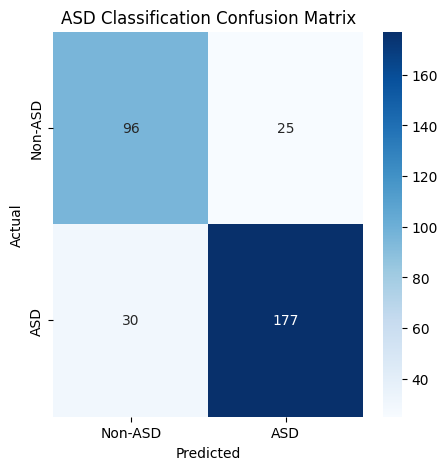

Action Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.75      0.87      0.81        31
           2       0.83      0.83      0.83        24
           3       0.93      0.97      0.95        29
           4       0.91      0.82      0.86        38
           5       0.68      0.72      0.70        29
           6       0.84      0.73      0.78        44
           7       0.82      1.00      0.90        31
           8       0.85      0.81      0.83        21
           9       0.90      0.87      0.88        30
          10       1.00      0.83      0.91        29

    accuracy                           0.85       328
   macro avg       0.85      0.85      0.85       328
weighted avg       0.85      0.85      0.85       328



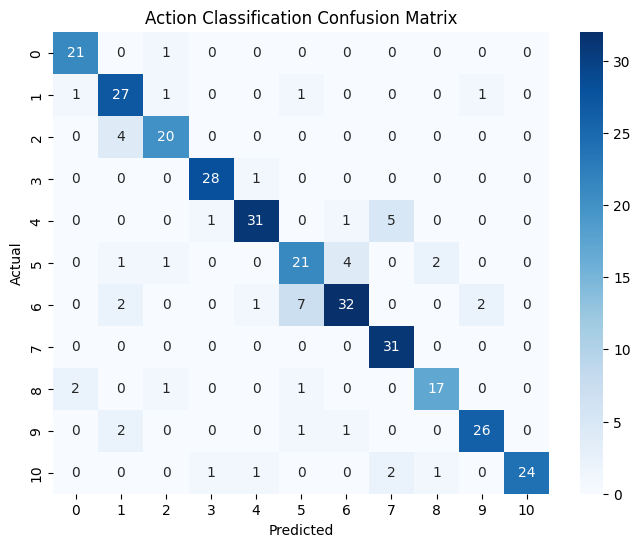

In [ ]:
# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store labels and predictions
all_asd_preds = []
all_action_preds = []
all_asd_labels = []
all_action_labels = []

# Disable gradient calculations for inference
with torch.no_grad():
    for features, asd_labels, action_labels in val_loader:  # Change to test_loader if needed
        features, asd_labels, action_labels = features.to(device), asd_labels.to(device), action_labels.to(device)

        # Forward pass
        asd_pred, action_pred = model(features)

        # Convert ASD predictions to binary (threshold 0.5)
        asd_preds = (asd_pred.squeeze() > 0.5).int().cpu().numpy()
        all_asd_preds.extend(asd_preds.tolist())  # Ensure proper format
        all_asd_labels.extend(asd_labels.cpu().numpy().tolist())

        # Convert Action predictions to class indices
        action_preds = torch.argmax(action_pred, dim=1).cpu().numpy()
        all_action_preds.extend(action_preds.tolist())
        all_action_labels.extend(action_labels.cpu().numpy().tolist())

# Ensure correct shape
all_asd_labels = np.array(all_asd_labels).flatten()
all_asd_preds = np.array(all_asd_preds).flatten()
all_action_labels = np.array(all_action_labels).flatten()
all_action_preds = np.array(all_action_preds).flatten()

# Print classification report for ASD
print("ASD Classification Report:")
print(classification_report(all_asd_labels, all_asd_preds, target_names=["Non-ASD", "ASD"]))

# Generate confusion matrix for ASD classification
asd_conf_matrix = confusion_matrix(all_asd_labels, all_asd_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(asd_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-ASD", "ASD"], yticklabels=["Non-ASD", "ASD"])
plt.title("ASD Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("asd_confusion_matrix.png")  # Save image
plt.show()

# Print classification report for Action classification
print("Action Classification Report:")
print(classification_report(all_action_labels, all_action_preds))

# Generate confusion matrix for Action classification
action_conf_matrix = confusion_matrix(all_action_labels, all_action_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(action_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Action Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("action_confusion_matrix.png")  # Save image
plt.show()


In [ ]:
# ==================== 1. Authenticate and Access Google Cloud Storage ====================
from google.colab import auth
auth.authenticate_user()  # Authenticate Colab session

import os
from google.cloud import storage

# Replace these with your own project and bucket details
project_id = "still-chassis-227311"
BUCKET_NAME = "mmasd"
DATASET_FOLDER_PATH = "3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/"  # Folder path inside GCS

client = storage.Client(project=project_id)
bucket = client.bucket(BUCKET_NAME)

# Function to list all CSV files in a given folder (automatically reads all files)
def list_all_csv_files(bucket, prefix):
    return [blob.name for blob in bucket.list_blobs(prefix=prefix) if blob.name.endswith(".csv")]

# List all CSV files automatically
file_list = list_all_csv_files(bucket, DATASET_FOLDER_PATH)
print("Files found:", file_list)

# ==================== 2. Custom Dataset to Load Data from Google Cloud Storage ====================
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from io import StringIO  # For reading CSV from string

class GCSBodyMovementDataset(Dataset):
    def __init__(self, file_list, bucket_name):
        self.file_list = file_list
        self.bucket_name = bucket_name
        self.client = storage.Client()  # Use default credentials from Colab
        self.bucket = self.client.bucket(bucket_name)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        blob = self.bucket.blob(file_path)
        csv_data = blob.download_as_string().decode('utf-8')  # Download CSV as string
        data = pd.read_csv(StringIO(csv_data))

        # Features: drop columns if they exist
        columns_to_drop = ['Participant_ID', 'ASD_Label', 'Action_Label']
        existing_columns = data.columns
        columns_to_drop = [col for col in columns_to_drop if col in existing_columns]
        features = data.drop(columns=columns_to_drop, axis=1)
        features_tensor = torch.tensor(features.values, dtype=torch.float32)

        # Labels:
        # ASD: get the first value of ASD_Label, convert to 1.0 if >0 else 0.0
        asd_label = data['ASD_Label'].iloc[0]
        asd_label = 1.0 if asd_label > 0 else 0.0
        asd_label = torch.tensor(asd_label, dtype=torch.float32)

        # Action: get the first value of Action_Label as a long tensor
        action_label = torch.tensor(data['Action_Label'].iloc[0], dtype=torch.long)

        return features_tensor, asd_label, action_label

# ==================== 3. Create Dataset and DataLoaders ====================
dataset = GCSBodyMovementDataset(file_list, BUCKET_NAME)

# For very small datasets, we adjust the split ratios.
total_samples = len(dataset)
print("Total samples:", total_samples)
# For example, use 60% training, 20% validation, 20% test
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size
print("Train/Val/Test sizes:", train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==================== 4. Define the Multi-Task Model (1D-CNN + BiLSTM) ====================
import torch.nn as nn

class MultiTaskASDModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(MultiTaskASDModel, self).__init__()
        # 1D-CNN for spatial feature extraction
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # BiLSTM for temporal modeling (bidirectional)
        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout_rate)
        # Fully connected layers for classification (bidirectional LSTM => hidden_size*2)
        self.fc_asd = nn.Linear(hidden_size * 2, 1)       # Binary classification for ASD
        self.fc_action = nn.Linear(hidden_size * 2, num_classes)  # Multi-class classification for actions

    def forward(self, x):
        # Input x: (batch, time, features)
        x = x.permute(0, 2, 1)  # Rearrange for CNN: (batch, features, time)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.permute(0, 2, 1)  # Rearrange back for LSTM: (batch, time, features)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Use output from last time step
        lstm_out = self.dropout(lstm_out)
        asd_pred = torch.sigmoid(self.fc_asd(lstm_out))  # Binary output for ASD (batch, 1)
        action_pred = self.fc_action(lstm_out)           # Raw logits for action classification
        return asd_pred, action_pred

# ==================== 5. Training Setup ====================
input_size = 75         # Number of features (e.g., body part coordinates)
hidden_size = 64
num_layers = 2
num_classes = 11        # Number of action classes

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskASDModel(input_size, hidden_size, num_layers, num_classes).to(device)

criterion_asd = nn.BCELoss()          # Binary Cross-Entropy for ASD
criterion_action = nn.CrossEntropyLoss()  # Cross-Entropy for Action classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# ==================== 6. Training Loop with Validation and Early Stopping ====================
num_epochs = 100
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_asd = 0
    correct_action = 0
    total_samples = 0

    for features, asd_labels, action_labels in train_loader:
        features = features.to(device)
        asd_labels = asd_labels.to(device)
        action_labels = action_labels.to(device)

        optimizer.zero_grad()
        asd_pred, action_pred = model(features)
        # Reshape predictions and labels to (batch,) for BCE loss
        loss_asd = criterion_asd(asd_pred.view(-1), asd_labels.view(-1))
        loss_action = criterion_action(action_pred, action_labels)
        loss = loss_asd + loss_action
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        correct_asd += ((asd_pred.view(-1) > 0.5) == asd_labels.view(-1)).sum().item()
        correct_action += (torch.argmax(action_pred, dim=1) == action_labels).sum().item()

    avg_train_loss = train_loss / total_samples
    train_asd_acc = 100 * correct_asd / total_samples
    train_action_acc = 100 * correct_action / total_samples

    # Validation step
    model.eval()
    val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for features, asd_labels, action_labels in val_loader:
            features = features.to(device)
            asd_labels = asd_labels.to(device)
            action_labels = action_labels.to(device)

            asd_pred, action_pred = model(features)
            loss_asd = criterion_asd(asd_pred.view(-1), asd_labels.view(-1))
            loss_action = criterion_action(action_pred, action_labels)
            loss = loss_asd + loss_action
            val_loss += loss.item() * features.size(0)
            val_samples += features.size(0)

    avg_val_loss = val_loss / val_samples
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train ASD Acc: {train_asd_acc:.2f}%, Train Action Acc: {train_action_acc:.2f}%")

"""    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_multitask_asd_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break"""

print("Training Complete!")


Files found: ['3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_4_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_5_1.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_7_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_4_1.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_9_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_002_n_3_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100: Train Loss: 2.9575, Val Loss: 2.7100, Train ASD Acc: 57.25%, Train Action Acc: 19.64%
Epoch 2/100: Train Loss: 2.4717, Val Loss: 2.2737, Train ASD Acc: 59.39%, Train Action Acc: 33.08%
Epoch 3/100: Train Loss: 2.2630, Val Loss: 2.0718, Train ASD Acc: 62.80%, Train Action Acc: 37.15%
Epoch 4/100: Train Loss: 2.0829, Val Loss: 2.0884, Train ASD Acc: 65.29%, Train Action Acc: 43.10%
Epoch 5/100: Train Loss: 2.0209, Val Loss: 1.9243, Train ASD Acc: 65.75%, Train Action Acc: 46.87%
Epoch 6/100: Train Loss: 1.9097, Val Loss: 1.8109, Train ASD Acc: 66.11%, Train Action Acc: 51.45%
Epoch 7/100: Train Loss: 1.8780, Val Loss: 1.8771, Train ASD Acc: 66.77%, Train Action Acc: 53.99%
Epoch 8/100: Train Loss: 1.7837, Val Loss: 1.8117, Train ASD Acc: 67.02%, Train Action Acc: 55.27%
Epoch 9/100: Train Loss: 1.6860, Val Loss: 1.7235, Train ASD Acc: 68.55%, Train Action Acc: 58.52%
Epoch 10/100: Train Loss: 1.7778, Val Loss: 1.8233, Train ASD Acc: 68.50%, Train Action Acc: 56.34%
Epoch 11/

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and ground truth for confusion matrix
asd_preds_list = []
asd_labels_list = []
action_preds_list = []
action_labels_list = []

total_loss = 0.0
total_samples = 0
total_asd_correct = 0
total_action_correct = 0

with torch.no_grad():
    for batch in test_loader:
        # Unpack the batch
        inputs, asd_labels, action_labels = batch

        # Move data to the proper device
        inputs = inputs.to(device)
        asd_labels = asd_labels.to(device)
        action_labels = action_labels.to(device)

        # Forward pass through the model
        outputs_asd, outputs_action = model(inputs)

        # Compute losses for both tasks
        loss_asd = criterion_asd(outputs_asd.view(-1), asd_labels.view(-1))
        loss_action = criterion_action(outputs_action, action_labels)
        loss = loss_asd + loss_action

        # Accumulate total loss
        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        # Predictions:
        # For ASD (binary): threshold the sigmoid output at 0.5
        asd_preds = (outputs_asd.view(-1) > 0.5).float()
        # For Action (multi-class): argmax over the logits
        action_preds = torch.argmax(outputs_action, dim=1)

        # Update correct counts
        total_asd_correct += (asd_preds == asd_labels.view(-1)).sum().item()
        total_action_correct += (action_preds == action_labels).sum().item()

        # Collect for confusion matrix
        asd_preds_list.extend(asd_preds.cpu().numpy())
        asd_labels_list.extend(asd_labels.view(-1).cpu().numpy())
        action_preds_list.extend(action_preds.cpu().numpy())
        action_labels_list.extend(action_labels.cpu().numpy())

# Calculate average loss and accuracy
avg_loss = total_loss / total_samples
asd_accuracy = 100.0 * total_asd_correct / total_samples
action_accuracy = 100.0 * total_action_correct / total_samples

print(f"Test Loss: {avg_loss:.4f}")
print(f"ASD Accuracy: {asd_accuracy:.2f}%")
print(f"Action Accuracy: {action_accuracy:.2f}%")

# ---------- Confusion Matrices ----------
# ASD: binary confusion matrix
cm_asd = confusion_matrix(asd_labels_list, asd_preds_list)
print("\nASD Confusion Matrix:")
print(cm_asd)

# Action: multi-class confusion matrix
cm_action = confusion_matrix(action_labels_list, action_preds_list)
print("\nAction Confusion Matrix:")
print(cm_action)


Test Loss: 1.2684
ASD Accuracy: 82.16%
Action Accuracy: 75.30%

ASD Confusion Matrix:
[[197  47]
 [ 70 342]]

Action Confusion Matrix:
[[33  0  3  0  1  2  0  0  2  1  1]
 [ 8 36 10  0  0  2  4  1  0  0  0]
 [ 3  5 36  0  0  1  0  0  3  3  0]
 [ 0  0  0 57  4  0  0  3  1  0  0]
 [ 2  0  0  2 64  2  0 10  1  1  1]
 [ 0  3  0  0  2 37 13  0  1  1  0]
 [ 0  2  0  0  2 14 55  0  0  1  0]
 [ 0  0  0  3  7  0  0 47  2  1  0]
 [ 0  2  1  0  4  2  2  2 26  1  0]
 [ 1  2  0  0  2  5  1  1  1 45  0]
 [ 0  0  0  0  2  0  0  4  0  0 58]]


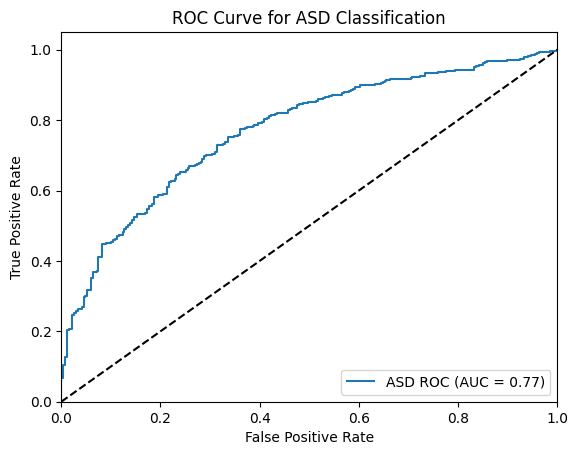

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ------------------------- ASD ROC Curve -------------------------
model.eval()  # Set model to evaluation mode

all_asd_probs = []
all_asd_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, asd_labels, _ = batch  # ignore action labels here
        inputs = inputs.to(device)
        asd_labels = asd_labels.to(device)

        # Forward pass: get outputs for ASD only
        outputs_asd, _ = model(inputs)

        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(outputs_asd).view(-1)
        all_asd_probs.extend(probs.cpu().numpy())
        all_asd_labels.extend(asd_labels.view(-1).cpu().numpy())

# Compute ROC curve and AUC for ASD
fpr_asd, tpr_asd, _ = roc_curve(all_asd_labels, all_asd_probs)
roc_auc_asd = auc(fpr_asd, tpr_asd)

plt.figure()
plt.plot(fpr_asd, tpr_asd, label='ASD ROC (AUC = {:.2f})'.format(roc_auc_asd))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ASD Classification')
plt.legend(loc="lower right")
plt.show()


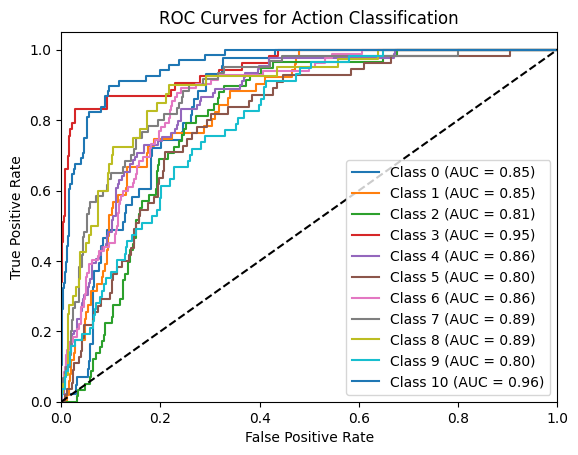

In [ ]:

# ------------------------- Action ROC Curves -------------------------
# For multi-class classification, we compute ROC curves in a one-vs-all manner.
all_action_probs = []
all_action_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, _, action_labels = batch
        inputs = inputs.to(device)
        action_labels = action_labels.to(device)

        # Forward pass: get outputs for action classification
        _, outputs_action = model(inputs)
        # Apply softmax to get probabilities per class
        probs = torch.softmax(outputs_action, dim=1)
        all_action_probs.append(probs.cpu().numpy())
        all_action_labels.append(action_labels.cpu().numpy())

all_action_probs = np.concatenate(all_action_probs, axis=0)  # shape: (n_samples, n_classes)
all_action_labels = np.concatenate(all_action_labels, axis=0)

n_classes = all_action_probs.shape[1]
# Binarize the ground truth labels for ROC computation
y_test_bin = label_binarize(all_action_labels, classes=list(range(n_classes)))  # shape: (n_samples, n_classes)

fpr_action = dict()
tpr_action = dict()
roc_auc_action = dict()

for i in range(n_classes):
    fpr_action[i], tpr_action[i], _ = roc_curve(y_test_bin[:, i], all_action_probs[:, i])
    roc_auc_action[i] = auc(fpr_action[i], tpr_action[i])

# Plot ROC curves for each action class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr_action[i], tpr_action[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc_action[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Action Classification')
plt.legend(loc="lower right")
plt.show()


Total files found: 3276
Sample files: ['3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_4_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_5_1.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_7_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_4_1.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_9_0.csv']
Total samples: 3276
Train/Val/Test sizes: 1965 655 656

Training Proposed: lr=0.001, num_filters=32, lstm_hidden_size=32, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0216 | Val Loss: 2.8954 | Tra

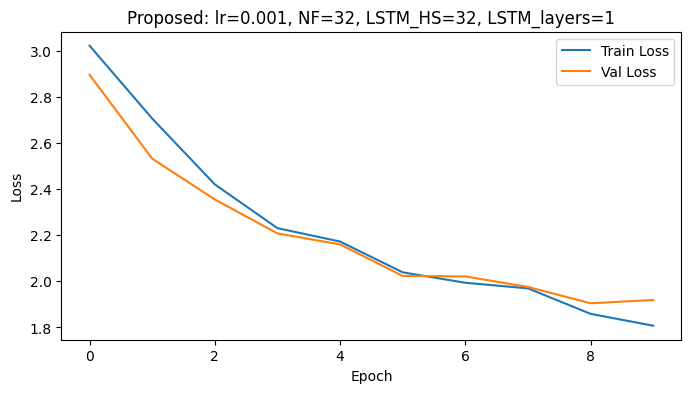


Training Proposed: lr=0.001, num_filters=32, lstm_hidden_size=32, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0332 | Val Loss: 2.9350 | Train ASD Acc: 55.17% | Train Action Acc: 12.98%
Epoch 2/10 | Train Loss: 2.7926 | Val Loss: 2.7218 | Train ASD Acc: 62.14% | Train Action Acc: 20.00%
Epoch 3/10 | Train Loss: 2.6369 | Val Loss: 2.5916 | Train ASD Acc: 63.72% | Train Action Acc: 23.66%
Epoch 4/10 | Train Loss: 2.4597 | Val Loss: 2.4546 | Train ASD Acc: 63.77% | Train Action Acc: 29.41%
Epoch 5/10 | Train Loss: 2.3347 | Val Loss: 2.3285 | Train ASD Acc: 67.02% | Train Action Acc: 31.76%
Epoch 6/10 | Train Loss: 2.2596 | Val Loss: 2.2862 | Train ASD Acc: 67.07% | Train Action Acc: 34.35%
Epoch 7/10 | Train Loss: 2.2111 | Val Loss: 2.2519 | Train ASD Acc: 67.89% | Train Action Acc: 34.86%
Epoch 8/10 | Train Loss: 2.1639 | Val Loss: 2.1607 | Train ASD Acc: 68.50% | Train Action Acc: 37.05%
Epoch 9/10 | Train Loss: 2.0804 | Val Loss: 2.0940 | Train ASD Acc: 68.75% | Train Action Acc: 40.1

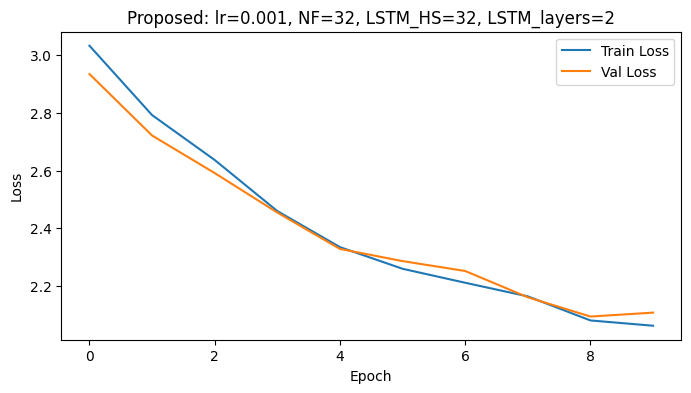


Training Proposed: lr=0.001, num_filters=32, lstm_hidden_size=64, lstm_num_layers=1
Epoch 1/10 | Train Loss: 2.9820 | Val Loss: 2.8357 | Train ASD Acc: 58.93% | Train Action Acc: 15.62%
Epoch 2/10 | Train Loss: 2.5876 | Val Loss: 2.4166 | Train ASD Acc: 63.56% | Train Action Acc: 28.30%
Epoch 3/10 | Train Loss: 2.2887 | Val Loss: 2.2427 | Train ASD Acc: 64.48% | Train Action Acc: 35.88%
Epoch 4/10 | Train Loss: 2.1171 | Val Loss: 2.1542 | Train ASD Acc: 66.72% | Train Action Acc: 41.88%
Epoch 5/10 | Train Loss: 2.0844 | Val Loss: 2.2160 | Train ASD Acc: 66.31% | Train Action Acc: 43.56%
Epoch 6/10 | Train Loss: 2.0183 | Val Loss: 2.0753 | Train ASD Acc: 67.28% | Train Action Acc: 46.67%
Epoch 7/10 | Train Loss: 1.9284 | Val Loss: 2.1216 | Train ASD Acc: 67.18% | Train Action Acc: 49.36%
Epoch 8/10 | Train Loss: 1.8879 | Val Loss: 1.9546 | Train ASD Acc: 68.35% | Train Action Acc: 51.70%
Epoch 9/10 | Train Loss: 1.7796 | Val Loss: 1.9153 | Train ASD Acc: 70.69% | Train Action Acc: 53.0

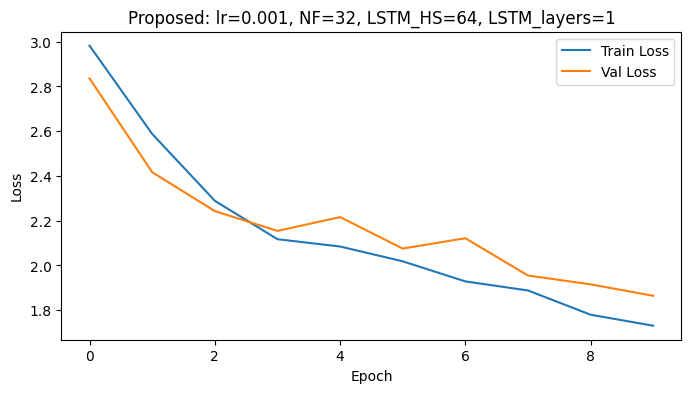


Training Proposed: lr=0.001, num_filters=32, lstm_hidden_size=64, lstm_num_layers=2
Epoch 1/10 | Train Loss: 2.9957 | Val Loss: 2.7958 | Train ASD Acc: 57.76% | Train Action Acc: 15.88%
Epoch 2/10 | Train Loss: 2.6347 | Val Loss: 2.4848 | Train ASD Acc: 60.36% | Train Action Acc: 26.62%
Epoch 3/10 | Train Loss: 2.3736 | Val Loss: 2.3003 | Train ASD Acc: 66.01% | Train Action Acc: 32.82%
Epoch 4/10 | Train Loss: 2.1601 | Val Loss: 2.2547 | Train ASD Acc: 66.92% | Train Action Acc: 41.53%
Epoch 5/10 | Train Loss: 2.0590 | Val Loss: 2.0844 | Train ASD Acc: 66.72% | Train Action Acc: 44.33%
Epoch 6/10 | Train Loss: 2.0224 | Val Loss: 2.1496 | Train ASD Acc: 67.74% | Train Action Acc: 45.24%
Epoch 7/10 | Train Loss: 1.9144 | Val Loss: 2.0002 | Train ASD Acc: 66.97% | Train Action Acc: 49.16%
Epoch 8/10 | Train Loss: 1.8881 | Val Loss: 1.8998 | Train ASD Acc: 66.51% | Train Action Acc: 49.97%
Epoch 9/10 | Train Loss: 1.7723 | Val Loss: 2.0299 | Train ASD Acc: 69.41% | Train Action Acc: 54.0

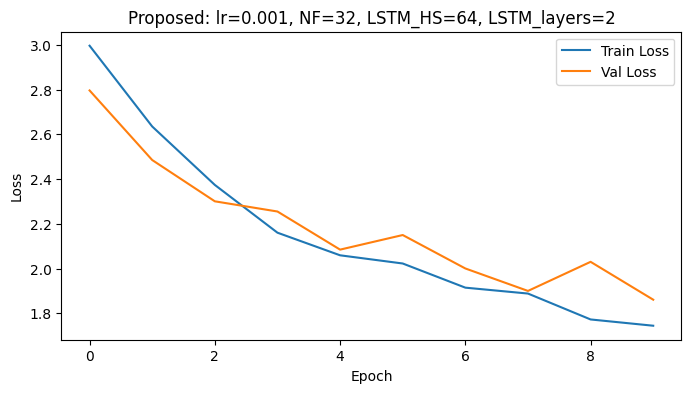


Training Proposed: lr=0.001, num_filters=64, lstm_hidden_size=32, lstm_num_layers=1
Epoch 1/10 | Train Loss: 2.9409 | Val Loss: 2.7307 | Train ASD Acc: 56.54% | Train Action Acc: 16.79%
Epoch 2/10 | Train Loss: 2.5632 | Val Loss: 2.3893 | Train ASD Acc: 62.39% | Train Action Acc: 29.16%
Epoch 3/10 | Train Loss: 2.3029 | Val Loss: 2.3324 | Train ASD Acc: 64.43% | Train Action Acc: 39.39%
Epoch 4/10 | Train Loss: 2.1684 | Val Loss: 2.1044 | Train ASD Acc: 66.11% | Train Action Acc: 41.93%
Epoch 5/10 | Train Loss: 2.0453 | Val Loss: 2.0889 | Train ASD Acc: 68.14% | Train Action Acc: 46.41%
Epoch 6/10 | Train Loss: 1.9212 | Val Loss: 1.9522 | Train ASD Acc: 69.11% | Train Action Acc: 51.15%
Epoch 7/10 | Train Loss: 1.8253 | Val Loss: 1.9361 | Train ASD Acc: 69.82% | Train Action Acc: 54.15%
Epoch 8/10 | Train Loss: 1.7932 | Val Loss: 1.8569 | Train ASD Acc: 71.15% | Train Action Acc: 53.38%
Epoch 9/10 | Train Loss: 1.7224 | Val Loss: 1.8487 | Train ASD Acc: 70.74% | Train Action Acc: 55.1

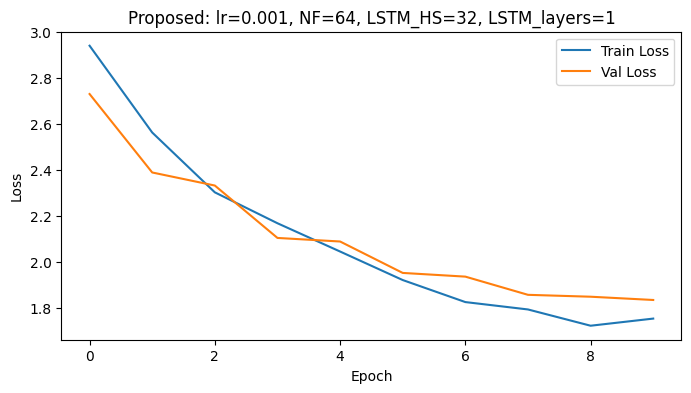


Training Proposed: lr=0.001, num_filters=64, lstm_hidden_size=32, lstm_num_layers=2
Epoch 1/10 | Train Loss: 2.9995 | Val Loss: 2.8070 | Train ASD Acc: 58.12% | Train Action Acc: 16.23%
Epoch 2/10 | Train Loss: 2.6631 | Val Loss: 2.5357 | Train ASD Acc: 63.51% | Train Action Acc: 23.92%
Epoch 3/10 | Train Loss: 2.4554 | Val Loss: 2.3918 | Train ASD Acc: 64.94% | Train Action Acc: 29.26%
Epoch 4/10 | Train Loss: 2.3144 | Val Loss: 2.2753 | Train ASD Acc: 66.82% | Train Action Acc: 35.06%
Epoch 5/10 | Train Loss: 2.2202 | Val Loss: 2.2184 | Train ASD Acc: 66.82% | Train Action Acc: 38.93%
Epoch 6/10 | Train Loss: 2.1927 | Val Loss: 2.2209 | Train ASD Acc: 66.36% | Train Action Acc: 39.59%
Epoch 7/10 | Train Loss: 2.1227 | Val Loss: 2.1381 | Train ASD Acc: 67.18% | Train Action Acc: 39.85%
Epoch 8/10 | Train Loss: 2.0714 | Val Loss: 2.2472 | Train ASD Acc: 67.68% | Train Action Acc: 41.02%
Epoch 9/10 | Train Loss: 2.0047 | Val Loss: 2.1255 | Train ASD Acc: 70.23% | Train Action Acc: 43.2

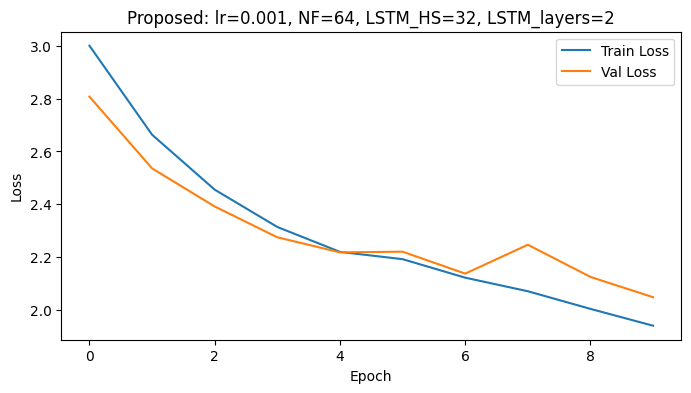


Training Proposed: lr=0.001, num_filters=64, lstm_hidden_size=64, lstm_num_layers=1
Epoch 1/10 | Train Loss: 2.9062 | Val Loss: 2.6643 | Train ASD Acc: 59.03% | Train Action Acc: 17.00%
Epoch 2/10 | Train Loss: 2.4756 | Val Loss: 2.3218 | Train ASD Acc: 62.39% | Train Action Acc: 29.57%
Epoch 3/10 | Train Loss: 2.2338 | Val Loss: 2.1755 | Train ASD Acc: 67.94% | Train Action Acc: 37.61%
Epoch 4/10 | Train Loss: 2.0770 | Val Loss: 2.1179 | Train ASD Acc: 67.84% | Train Action Acc: 42.29%
Epoch 5/10 | Train Loss: 2.0032 | Val Loss: 1.9861 | Train ASD Acc: 68.65% | Train Action Acc: 45.04%
Epoch 6/10 | Train Loss: 1.8894 | Val Loss: 1.9571 | Train ASD Acc: 69.36% | Train Action Acc: 50.69%
Epoch 7/10 | Train Loss: 1.8575 | Val Loss: 1.9575 | Train ASD Acc: 68.96% | Train Action Acc: 49.92%
Epoch 8/10 | Train Loss: 1.7523 | Val Loss: 1.9050 | Train ASD Acc: 70.74% | Train Action Acc: 53.54%
Epoch 9/10 | Train Loss: 1.7532 | Val Loss: 1.8820 | Train ASD Acc: 70.08% | Train Action Acc: 54.2

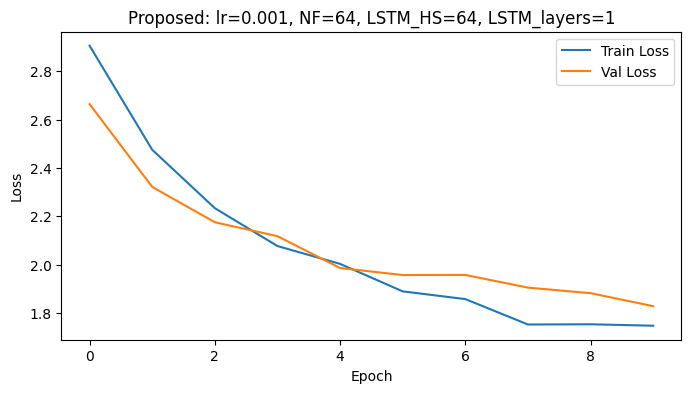


Training Proposed: lr=0.001, num_filters=64, lstm_hidden_size=64, lstm_num_layers=2
Epoch 1/10 | Train Loss: 2.9545 | Val Loss: 2.7147 | Train ASD Acc: 58.78% | Train Action Acc: 15.78%
Epoch 2/10 | Train Loss: 2.4836 | Val Loss: 2.4262 | Train ASD Acc: 64.17% | Train Action Acc: 31.91%
Epoch 3/10 | Train Loss: 2.2276 | Val Loss: 2.2665 | Train ASD Acc: 67.33% | Train Action Acc: 37.05%
Epoch 4/10 | Train Loss: 2.1223 | Val Loss: 2.0756 | Train ASD Acc: 67.38% | Train Action Acc: 39.59%
Epoch 5/10 | Train Loss: 2.0079 | Val Loss: 2.1555 | Train ASD Acc: 68.50% | Train Action Acc: 46.11%
Epoch 6/10 | Train Loss: 1.9440 | Val Loss: 2.0637 | Train ASD Acc: 66.82% | Train Action Acc: 47.07%
Epoch 7/10 | Train Loss: 1.8276 | Val Loss: 1.9284 | Train ASD Acc: 68.55% | Train Action Acc: 52.88%
Epoch 8/10 | Train Loss: 1.7731 | Val Loss: 1.9391 | Train ASD Acc: 68.60% | Train Action Acc: 56.13%
Epoch 9/10 | Train Loss: 1.6997 | Val Loss: 1.8893 | Train ASD Acc: 70.79% | Train Action Acc: 55.7

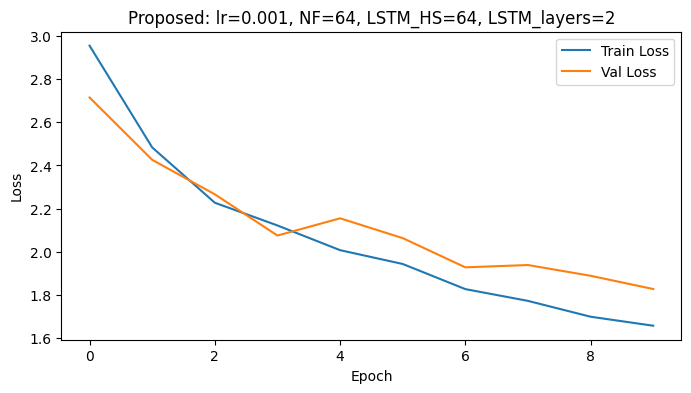


Training Proposed: lr=0.0005, num_filters=32, lstm_hidden_size=32, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0628 | Val Loss: 3.0079 | Train ASD Acc: 49.82% | Train Action Acc: 12.42%
Epoch 2/10 | Train Loss: 2.8932 | Val Loss: 2.7985 | Train ASD Acc: 57.66% | Train Action Acc: 20.97%
Epoch 3/10 | Train Loss: 2.6878 | Val Loss: 2.6003 | Train ASD Acc: 61.17% | Train Action Acc: 24.73%
Epoch 4/10 | Train Loss: 2.5398 | Val Loss: 2.4577 | Train ASD Acc: 61.32% | Train Action Acc: 32.06%
Epoch 5/10 | Train Loss: 2.3606 | Val Loss: 2.3542 | Train ASD Acc: 64.02% | Train Action Acc: 35.37%
Epoch 6/10 | Train Loss: 2.3067 | Val Loss: 2.2853 | Train ASD Acc: 63.26% | Train Action Acc: 36.39%
Epoch 7/10 | Train Loss: 2.2157 | Val Loss: 2.2397 | Train ASD Acc: 63.26% | Train Action Acc: 39.69%
Epoch 8/10 | Train Loss: 2.1554 | Val Loss: 2.1547 | Train ASD Acc: 65.50% | Train Action Acc: 41.48%
Epoch 9/10 | Train Loss: 2.0941 | Val Loss: 2.1356 | Train ASD Acc: 65.45% | Train Action Acc: 44.

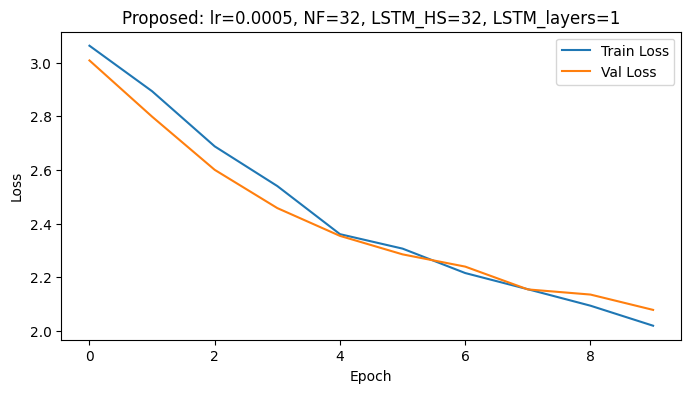


Training Proposed: lr=0.0005, num_filters=32, lstm_hidden_size=32, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0718 | Val Loss: 3.0406 | Train ASD Acc: 59.19% | Train Action Acc: 10.48%
Epoch 2/10 | Train Loss: 2.9351 | Val Loss: 2.8135 | Train ASD Acc: 59.75% | Train Action Acc: 18.27%
Epoch 3/10 | Train Loss: 2.6627 | Val Loss: 2.5662 | Train ASD Acc: 62.54% | Train Action Acc: 26.36%
Epoch 4/10 | Train Loss: 2.4851 | Val Loss: 2.4593 | Train ASD Acc: 63.66% | Train Action Acc: 29.36%
Epoch 5/10 | Train Loss: 2.3636 | Val Loss: 2.3402 | Train ASD Acc: 63.31% | Train Action Acc: 33.84%
Epoch 6/10 | Train Loss: 2.2814 | Val Loss: 2.2843 | Train ASD Acc: 62.85% | Train Action Acc: 38.02%
Epoch 7/10 | Train Loss: 2.1910 | Val Loss: 2.2498 | Train ASD Acc: 65.55% | Train Action Acc: 39.95%
Epoch 8/10 | Train Loss: 2.1761 | Val Loss: 2.2301 | Train ASD Acc: 65.55% | Train Action Acc: 40.97%
Epoch 9/10 | Train Loss: 2.1764 | Val Loss: 2.1774 | Train ASD Acc: 65.85% | Train Action Acc: 40.

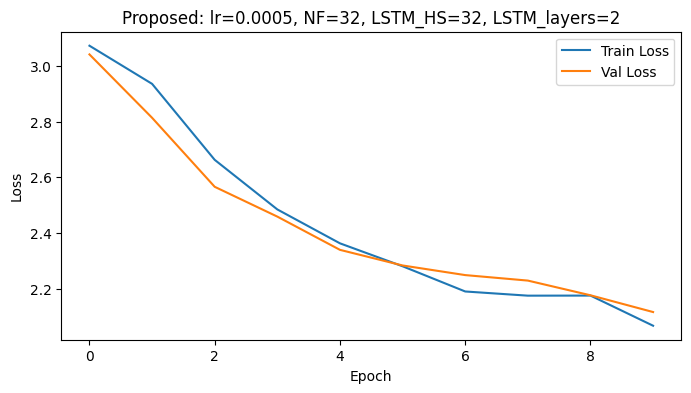


Training Proposed: lr=0.0005, num_filters=32, lstm_hidden_size=64, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0497 | Val Loss: 2.9744 | Train ASD Acc: 59.24% | Train Action Acc: 13.64%
Epoch 2/10 | Train Loss: 2.7953 | Val Loss: 2.6411 | Train ASD Acc: 59.64% | Train Action Acc: 22.39%
Epoch 3/10 | Train Loss: 2.5030 | Val Loss: 2.3910 | Train ASD Acc: 62.80% | Train Action Acc: 29.87%
Epoch 4/10 | Train Loss: 2.2778 | Val Loss: 2.2293 | Train ASD Acc: 65.34% | Train Action Acc: 36.79%
Epoch 5/10 | Train Loss: 2.1517 | Val Loss: 2.1890 | Train ASD Acc: 66.56% | Train Action Acc: 40.92%
Epoch 6/10 | Train Loss: 2.0771 | Val Loss: 2.1123 | Train ASD Acc: 68.30% | Train Action Acc: 44.27%
Epoch 7/10 | Train Loss: 1.9848 | Val Loss: 2.1031 | Train ASD Acc: 67.58% | Train Action Acc: 48.40%
Epoch 8/10 | Train Loss: 1.9276 | Val Loss: 2.0260 | Train ASD Acc: 68.19% | Train Action Acc: 48.65%
Epoch 9/10 | Train Loss: 1.8122 | Val Loss: 1.9066 | Train ASD Acc: 69.77% | Train Action Acc: 54.

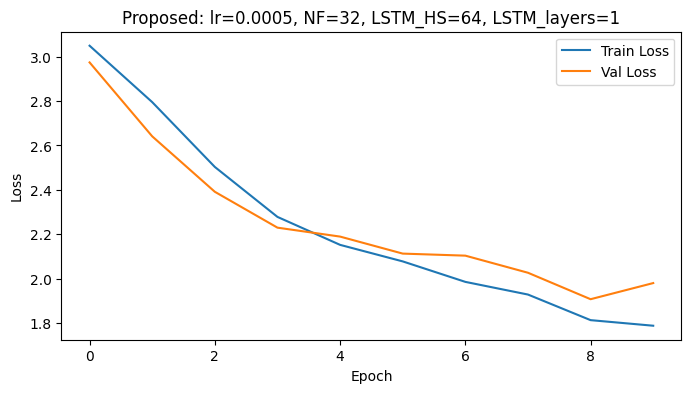


Training Proposed: lr=0.0005, num_filters=32, lstm_hidden_size=64, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0604 | Val Loss: 3.0103 | Train ASD Acc: 59.13% | Train Action Acc: 13.28%
Epoch 2/10 | Train Loss: 2.8797 | Val Loss: 2.7822 | Train ASD Acc: 57.91% | Train Action Acc: 19.75%
Epoch 3/10 | Train Loss: 2.6748 | Val Loss: 2.6542 | Train ASD Acc: 62.24% | Train Action Acc: 23.26%
Epoch 4/10 | Train Loss: 2.4845 | Val Loss: 2.4731 | Train ASD Acc: 62.80% | Train Action Acc: 29.57%
Epoch 5/10 | Train Loss: 2.3276 | Val Loss: 2.3975 | Train ASD Acc: 65.65% | Train Action Acc: 33.64%
Epoch 6/10 | Train Loss: 2.2693 | Val Loss: 2.2778 | Train ASD Acc: 65.70% | Train Action Acc: 36.28%
Epoch 7/10 | Train Loss: 2.1697 | Val Loss: 2.2364 | Train ASD Acc: 65.60% | Train Action Acc: 40.97%
Epoch 8/10 | Train Loss: 2.0781 | Val Loss: 2.1521 | Train ASD Acc: 67.33% | Train Action Acc: 41.27%
Epoch 9/10 | Train Loss: 2.0567 | Val Loss: 2.0952 | Train ASD Acc: 66.92% | Train Action Acc: 43.

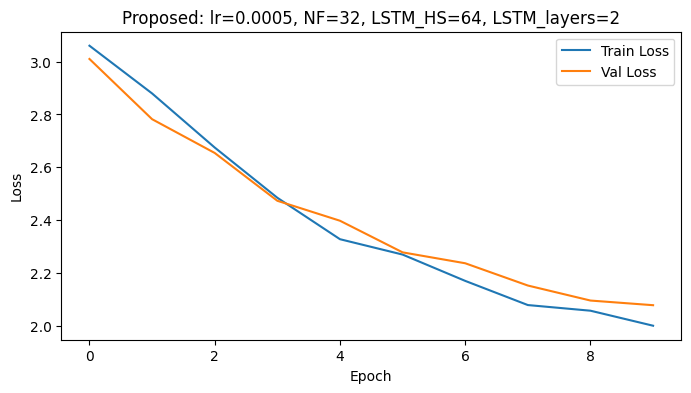


Training Proposed: lr=0.0005, num_filters=64, lstm_hidden_size=32, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0150 | Val Loss: 2.8869 | Train ASD Acc: 59.08% | Train Action Acc: 15.17%
Epoch 2/10 | Train Loss: 2.6927 | Val Loss: 2.5644 | Train ASD Acc: 62.09% | Train Action Acc: 24.89%
Epoch 3/10 | Train Loss: 2.4553 | Val Loss: 2.3797 | Train ASD Acc: 63.61% | Train Action Acc: 31.60%
Epoch 4/10 | Train Loss: 2.3114 | Val Loss: 2.3193 | Train ASD Acc: 66.41% | Train Action Acc: 38.52%
Epoch 5/10 | Train Loss: 2.2269 | Val Loss: 2.2665 | Train ASD Acc: 66.51% | Train Action Acc: 39.69%
Epoch 6/10 | Train Loss: 2.1270 | Val Loss: 2.1329 | Train ASD Acc: 66.97% | Train Action Acc: 45.14%
Epoch 7/10 | Train Loss: 2.0609 | Val Loss: 2.1324 | Train ASD Acc: 67.07% | Train Action Acc: 47.48%
Epoch 8/10 | Train Loss: 1.9957 | Val Loss: 2.0161 | Train ASD Acc: 67.48% | Train Action Acc: 49.16%
Epoch 9/10 | Train Loss: 1.9222 | Val Loss: 1.9761 | Train ASD Acc: 68.60% | Train Action Acc: 52.

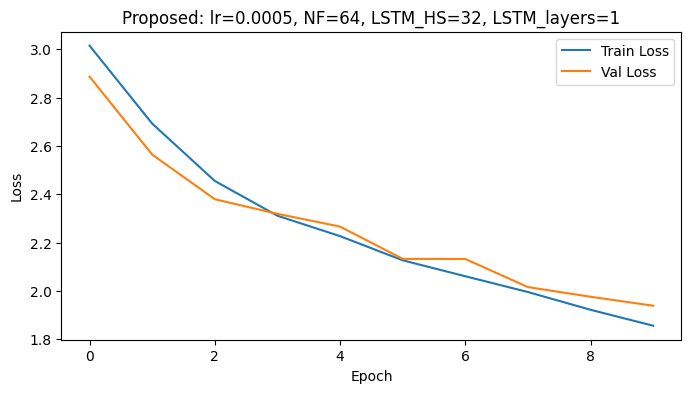


Training Proposed: lr=0.0005, num_filters=64, lstm_hidden_size=32, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0379 | Val Loss: 2.9604 | Train ASD Acc: 58.37% | Train Action Acc: 15.06%
Epoch 2/10 | Train Loss: 2.8777 | Val Loss: 2.8300 | Train ASD Acc: 59.54% | Train Action Acc: 21.12%
Epoch 3/10 | Train Loss: 2.7025 | Val Loss: 2.6290 | Train ASD Acc: 62.39% | Train Action Acc: 23.97%
Epoch 4/10 | Train Loss: 2.5309 | Val Loss: 2.4870 | Train ASD Acc: 65.95% | Train Action Acc: 29.01%
Epoch 5/10 | Train Loss: 2.3915 | Val Loss: 2.3847 | Train ASD Acc: 67.89% | Train Action Acc: 32.16%
Epoch 6/10 | Train Loss: 2.2742 | Val Loss: 2.3042 | Train ASD Acc: 69.62% | Train Action Acc: 36.39%
Epoch 7/10 | Train Loss: 2.2280 | Val Loss: 2.2264 | Train ASD Acc: 68.19% | Train Action Acc: 38.32%
Epoch 8/10 | Train Loss: 2.1682 | Val Loss: 2.2018 | Train ASD Acc: 68.45% | Train Action Acc: 41.27%
Epoch 9/10 | Train Loss: 2.0570 | Val Loss: 2.1032 | Train ASD Acc: 67.89% | Train Action Acc: 43.

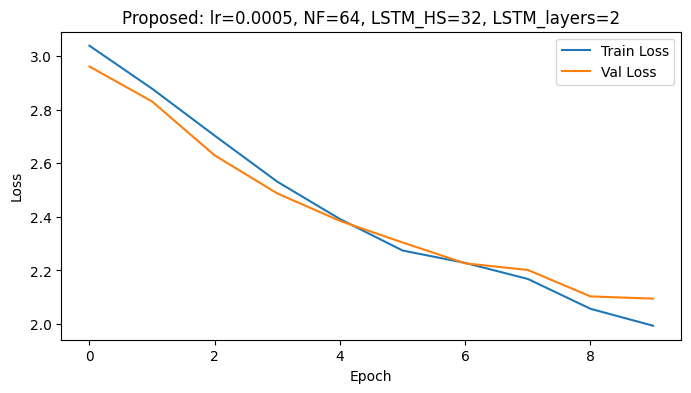


Training Proposed: lr=0.0005, num_filters=64, lstm_hidden_size=64, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0038 | Val Loss: 2.8403 | Train ASD Acc: 59.19% | Train Action Acc: 14.05%
Epoch 2/10 | Train Loss: 2.5646 | Val Loss: 2.4879 | Train ASD Acc: 63.05% | Train Action Acc: 28.50%
Epoch 3/10 | Train Loss: 2.3148 | Val Loss: 2.2753 | Train ASD Acc: 64.78% | Train Action Acc: 35.78%
Epoch 4/10 | Train Loss: 2.1589 | Val Loss: 2.1320 | Train ASD Acc: 66.72% | Train Action Acc: 42.19%
Epoch 5/10 | Train Loss: 2.0784 | Val Loss: 2.0759 | Train ASD Acc: 66.87% | Train Action Acc: 44.22%
Epoch 6/10 | Train Loss: 1.9480 | Val Loss: 2.0666 | Train ASD Acc: 67.79% | Train Action Acc: 48.75%
Epoch 7/10 | Train Loss: 1.8950 | Val Loss: 1.9895 | Train ASD Acc: 69.11% | Train Action Acc: 51.25%
Epoch 8/10 | Train Loss: 1.8169 | Val Loss: 1.9144 | Train ASD Acc: 69.77% | Train Action Acc: 53.13%
Epoch 9/10 | Train Loss: 1.7441 | Val Loss: 1.8721 | Train ASD Acc: 71.30% | Train Action Acc: 55.

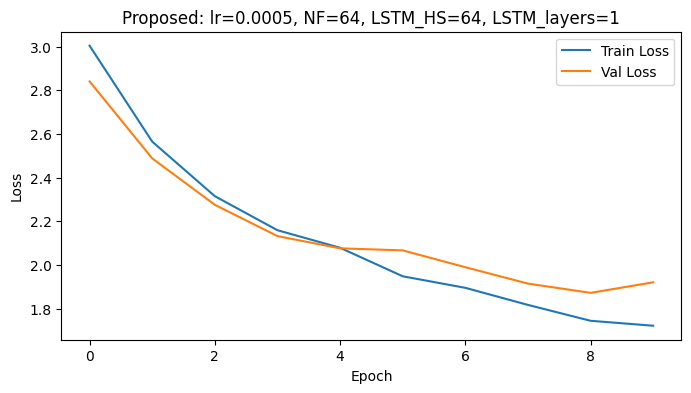


Training Proposed: lr=0.0005, num_filters=64, lstm_hidden_size=64, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0371 | Val Loss: 2.9411 | Train ASD Acc: 59.34% | Train Action Acc: 13.33%
Epoch 2/10 | Train Loss: 2.7856 | Val Loss: 2.6888 | Train ASD Acc: 60.56% | Train Action Acc: 20.97%
Epoch 3/10 | Train Loss: 2.5119 | Val Loss: 2.4199 | Train ASD Acc: 64.63% | Train Action Acc: 29.36%
Epoch 4/10 | Train Loss: 2.3072 | Val Loss: 2.3163 | Train ASD Acc: 66.97% | Train Action Acc: 34.86%
Epoch 5/10 | Train Loss: 2.1866 | Val Loss: 2.1879 | Train ASD Acc: 67.23% | Train Action Acc: 38.12%
Epoch 6/10 | Train Loss: 2.0816 | Val Loss: 2.1228 | Train ASD Acc: 69.01% | Train Action Acc: 41.88%
Epoch 7/10 | Train Loss: 2.0357 | Val Loss: 2.1161 | Train ASD Acc: 67.38% | Train Action Acc: 43.36%
Epoch 8/10 | Train Loss: 2.0373 | Val Loss: 2.0910 | Train ASD Acc: 69.11% | Train Action Acc: 41.48%
Epoch 9/10 | Train Loss: 1.9141 | Val Loss: 2.0017 | Train ASD Acc: 69.57% | Train Action Acc: 47.

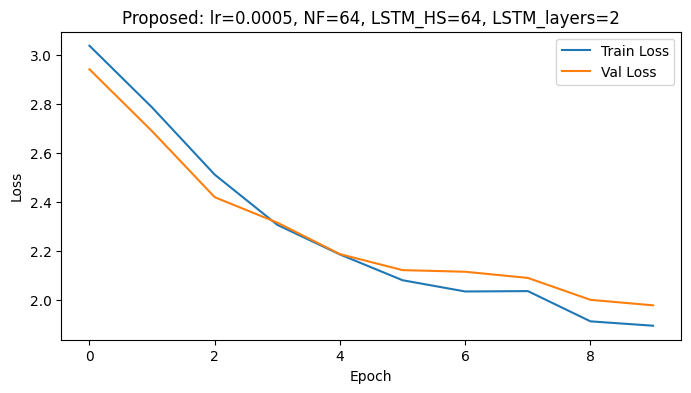


Training CNNOnly: lr=0.001, num_filters=32
Epoch 1/10 | Train Loss: 92.4385 | Val Loss: 3.0442 | Train ASD Acc: 57.15% | Train Action Acc: 15.27%
Epoch 2/10 | Train Loss: 3.0893 | Val Loss: 3.1594 | Train ASD Acc: 59.95% | Train Action Acc: 17.96%
Epoch 3/10 | Train Loss: 52.2679 | Val Loss: 3.1252 | Train ASD Acc: 60.10% | Train Action Acc: 19.95%
Epoch 4/10 | Train Loss: 27.7286 | Val Loss: 3.1201 | Train ASD Acc: 60.15% | Train Action Acc: 22.29%
Epoch 5/10 | Train Loss: 60.8803 | Val Loss: 3.1089 | Train ASD Acc: 59.90% | Train Action Acc: 21.83%
Epoch 6/10 | Train Loss: 22.4345 | Val Loss: 3.0807 | Train ASD Acc: 61.58% | Train Action Acc: 24.63%
Epoch 7/10 | Train Loss: 2.8917 | Val Loss: 3.0552 | Train ASD Acc: 61.27% | Train Action Acc: 23.26%
Epoch 8/10 | Train Loss: 2.7785 | Val Loss: 3.0537 | Train ASD Acc: 62.14% | Train Action Acc: 25.80%
Epoch 9/10 | Train Loss: 2.7124 | Val Loss: 3.0387 | Train ASD Acc: 62.39% | Train Action Acc: 25.55%
Epoch 10/10 | Train Loss: 2.7769 

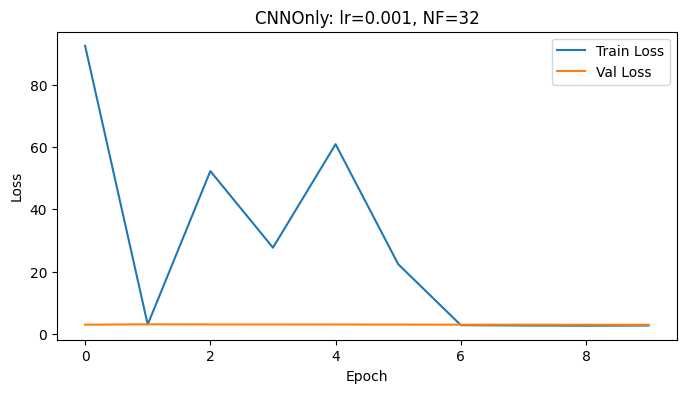


Training CNNOnly: lr=0.001, num_filters=64
Epoch 1/10 | Train Loss: 149.3755 | Val Loss: 3.1628 | Train ASD Acc: 50.33% | Train Action Acc: 11.86%
Epoch 2/10 | Train Loss: 44.2852 | Val Loss: 3.0857 | Train ASD Acc: 56.28% | Train Action Acc: 19.49%
Epoch 3/10 | Train Loss: 45.8108 | Val Loss: 3.0751 | Train ASD Acc: 58.63% | Train Action Acc: 22.34%
Epoch 4/10 | Train Loss: 97.2028 | Val Loss: 3.0788 | Train ASD Acc: 59.85% | Train Action Acc: 22.39%
Epoch 5/10 | Train Loss: 2.7904 | Val Loss: 3.0510 | Train ASD Acc: 60.41% | Train Action Acc: 24.99%
Epoch 6/10 | Train Loss: 22.6248 | Val Loss: 3.0161 | Train ASD Acc: 59.29% | Train Action Acc: 25.39%
Epoch 7/10 | Train Loss: 2.7244 | Val Loss: 3.0064 | Train ASD Acc: 59.95% | Train Action Acc: 27.84%
Epoch 8/10 | Train Loss: 2.8375 | Val Loss: 2.9993 | Train ASD Acc: 59.75% | Train Action Acc: 27.33%
Epoch 9/10 | Train Loss: 2.7952 | Val Loss: 2.9983 | Train ASD Acc: 60.97% | Train Action Acc: 30.79%
Epoch 10/10 | Train Loss: 10.636

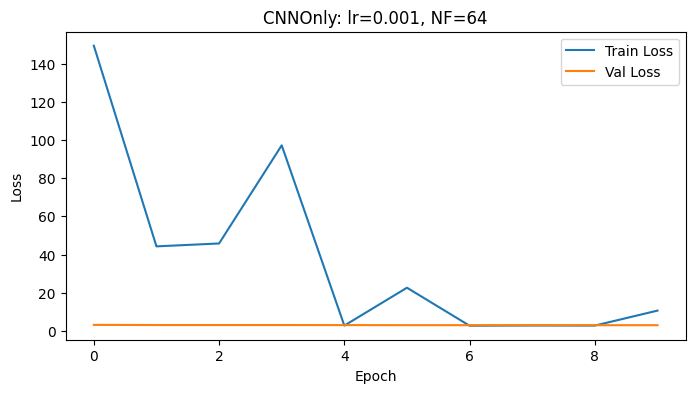


Training CNNOnly: lr=0.0005, num_filters=32
Epoch 1/10 | Train Loss: 133.3853 | Val Loss: 3.0367 | Train ASD Acc: 49.97% | Train Action Acc: 15.06%
Epoch 2/10 | Train Loss: 103.4236 | Val Loss: 3.0255 | Train ASD Acc: 54.86% | Train Action Acc: 17.66%
Epoch 3/10 | Train Loss: 3.1491 | Val Loss: 3.0233 | Train ASD Acc: 57.51% | Train Action Acc: 18.47%
Epoch 4/10 | Train Loss: 5.1112 | Val Loss: 3.0220 | Train ASD Acc: 56.90% | Train Action Acc: 18.07%
Epoch 5/10 | Train Loss: 53.4105 | Val Loss: 3.0201 | Train ASD Acc: 57.61% | Train Action Acc: 17.35%
Epoch 6/10 | Train Loss: 9.1807 | Val Loss: 3.0166 | Train ASD Acc: 57.96% | Train Action Acc: 17.76%
Epoch 7/10 | Train Loss: 3.7477 | Val Loss: 3.0157 | Train ASD Acc: 56.84% | Train Action Acc: 18.52%
Epoch 8/10 | Train Loss: 9.2262 | Val Loss: 3.1483 | Train ASD Acc: 57.30% | Train Action Acc: 18.47%
Epoch 9/10 | Train Loss: 14.2886 | Val Loss: 3.1453 | Train ASD Acc: 59.19% | Train Action Acc: 17.96%
Epoch 10/10 | Train Loss: 2.983

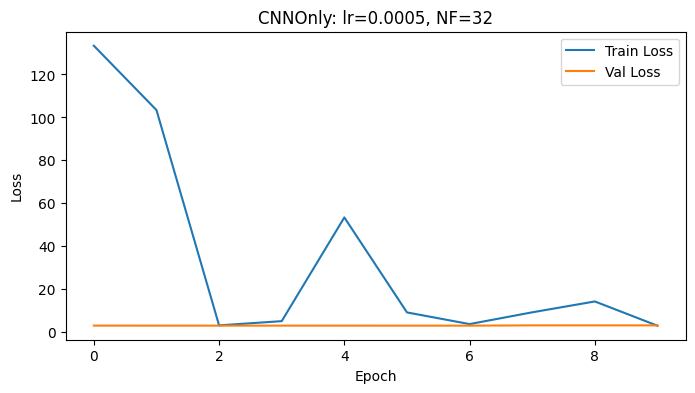


Training CNNOnly: lr=0.0005, num_filters=64
Epoch 1/10 | Train Loss: 62.9775 | Val Loss: 2.9994 | Train ASD Acc: 50.38% | Train Action Acc: 13.23%
Epoch 2/10 | Train Loss: 86.8435 | Val Loss: 2.9716 | Train ASD Acc: 56.49% | Train Action Acc: 18.02%
Epoch 3/10 | Train Loss: 25.7230 | Val Loss: 2.9544 | Train ASD Acc: 57.40% | Train Action Acc: 20.05%
Epoch 4/10 | Train Loss: 21.8942 | Val Loss: 2.9310 | Train ASD Acc: 59.54% | Train Action Acc: 22.19%
Epoch 5/10 | Train Loss: 2.9704 | Val Loss: 2.9081 | Train ASD Acc: 59.24% | Train Action Acc: 22.70%
Epoch 6/10 | Train Loss: 32.1447 | Val Loss: 2.8954 | Train ASD Acc: 60.00% | Train Action Acc: 23.46%
Epoch 7/10 | Train Loss: 2.9748 | Val Loss: 2.8807 | Train ASD Acc: 59.03% | Train Action Acc: 24.83%
Epoch 8/10 | Train Loss: 2.8488 | Val Loss: 2.9962 | Train ASD Acc: 61.12% | Train Action Acc: 23.31%
Epoch 9/10 | Train Loss: 3.0044 | Val Loss: 2.9815 | Train ASD Acc: 61.02% | Train Action Acc: 24.78%
Epoch 10/10 | Train Loss: 11.468

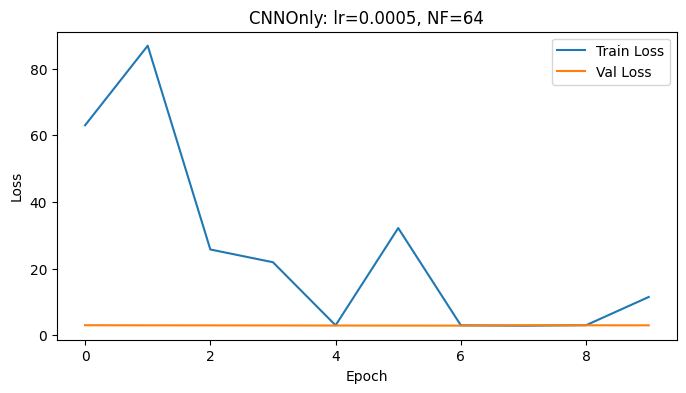


Training LSTMOnly: lr=0.001, lstm_hidden_size=32, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0481 | Val Loss: 2.9736 | Train ASD Acc: 55.47% | Train Action Acc: 16.69%
Epoch 2/10 | Train Loss: 2.8608 | Val Loss: 2.7831 | Train ASD Acc: 58.42% | Train Action Acc: 25.65%
Epoch 3/10 | Train Loss: 2.6877 | Val Loss: 2.6198 | Train ASD Acc: 61.27% | Train Action Acc: 26.77%
Epoch 4/10 | Train Loss: 2.5237 | Val Loss: 2.5500 | Train ASD Acc: 63.00% | Train Action Acc: 33.38%
Epoch 5/10 | Train Loss: 2.5193 | Val Loss: 2.4533 | Train ASD Acc: 61.68% | Train Action Acc: 32.98%
Epoch 6/10 | Train Loss: 2.3770 | Val Loss: 2.3448 | Train ASD Acc: 65.34% | Train Action Acc: 37.81%
Epoch 7/10 | Train Loss: 2.3148 | Val Loss: 2.3172 | Train ASD Acc: 66.31% | Train Action Acc: 39.49%
Epoch 8/10 | Train Loss: 2.2675 | Val Loss: 2.3306 | Train ASD Acc: 65.39% | Train Action Acc: 39.24%
Epoch 9/10 | Train Loss: 2.2638 | Val Loss: 2.2577 | Train ASD Acc: 67.38% | Train Action Acc: 39.75%
Epoch 10/10 |

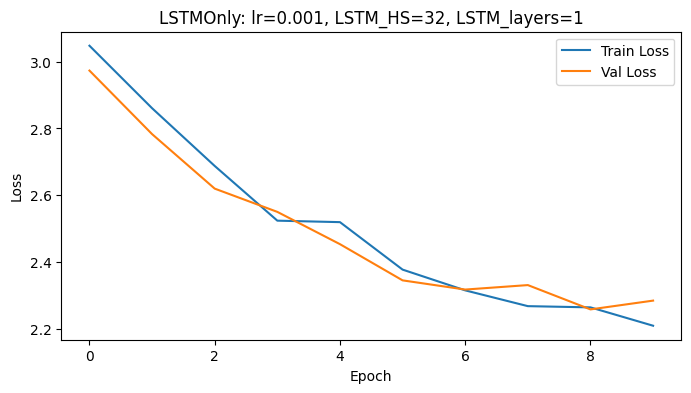


Training LSTMOnly: lr=0.001, lstm_hidden_size=32, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0333 | Val Loss: 2.9600 | Train ASD Acc: 58.22% | Train Action Acc: 16.28%
Epoch 2/10 | Train Loss: 2.8029 | Val Loss: 2.6488 | Train ASD Acc: 60.00% | Train Action Acc: 24.89%
Epoch 3/10 | Train Loss: 2.5241 | Val Loss: 2.5091 | Train ASD Acc: 63.31% | Train Action Acc: 33.94%
Epoch 4/10 | Train Loss: 2.4063 | Val Loss: 2.3697 | Train ASD Acc: 62.75% | Train Action Acc: 37.46%
Epoch 5/10 | Train Loss: 2.2715 | Val Loss: 2.2695 | Train ASD Acc: 64.22% | Train Action Acc: 41.02%
Epoch 6/10 | Train Loss: 2.2485 | Val Loss: 2.3400 | Train ASD Acc: 64.63% | Train Action Acc: 40.92%
Epoch 7/10 | Train Loss: 2.1953 | Val Loss: 2.2138 | Train ASD Acc: 66.01% | Train Action Acc: 41.83%
Epoch 8/10 | Train Loss: 2.1005 | Val Loss: 2.1643 | Train ASD Acc: 65.85% | Train Action Acc: 46.36%
Epoch 9/10 | Train Loss: 2.0621 | Val Loss: 2.0844 | Train ASD Acc: 66.77% | Train Action Acc: 48.65%
Epoch 10/10 |

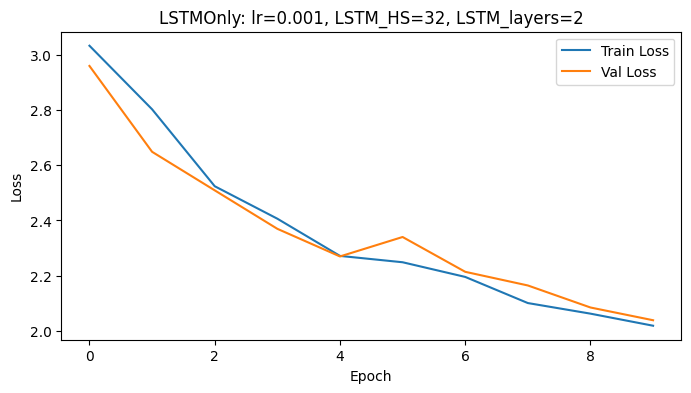


Training LSTMOnly: lr=0.001, lstm_hidden_size=64, lstm_num_layers=1
Epoch 1/10 | Train Loss: 2.9807 | Val Loss: 2.8409 | Train ASD Acc: 59.49% | Train Action Acc: 18.68%
Epoch 2/10 | Train Loss: 2.6343 | Val Loss: 2.5454 | Train ASD Acc: 62.04% | Train Action Acc: 27.84%
Epoch 3/10 | Train Loss: 2.5216 | Val Loss: 2.4759 | Train ASD Acc: 61.37% | Train Action Acc: 30.99%
Epoch 4/10 | Train Loss: 2.3968 | Val Loss: 2.3584 | Train ASD Acc: 63.41% | Train Action Acc: 36.03%
Epoch 5/10 | Train Loss: 2.3079 | Val Loss: 2.4117 | Train ASD Acc: 64.48% | Train Action Acc: 40.71%
Epoch 6/10 | Train Loss: 2.3288 | Val Loss: 2.6409 | Train ASD Acc: 64.12% | Train Action Acc: 39.44%
Epoch 7/10 | Train Loss: 2.3269 | Val Loss: 2.5056 | Train ASD Acc: 64.27% | Train Action Acc: 38.98%
Epoch 8/10 | Train Loss: 2.4177 | Val Loss: 2.3267 | Train ASD Acc: 63.66% | Train Action Acc: 38.47%
Epoch 9/10 | Train Loss: 2.1912 | Val Loss: 2.1926 | Train ASD Acc: 63.77% | Train Action Acc: 43.97%
Epoch 10/10 |

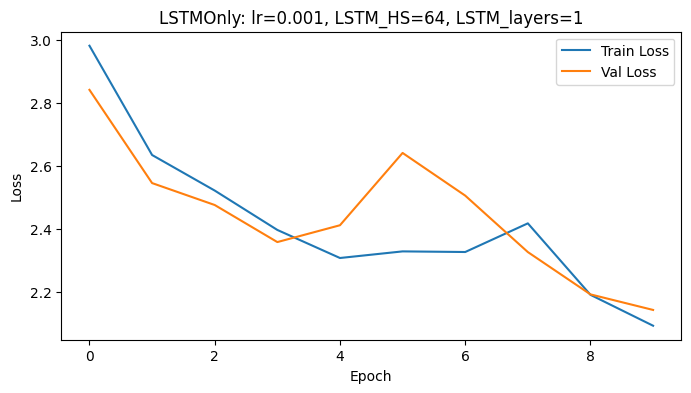


Training LSTMOnly: lr=0.001, lstm_hidden_size=64, lstm_num_layers=2
Epoch 1/10 | Train Loss: 2.9842 | Val Loss: 2.7764 | Train ASD Acc: 58.12% | Train Action Acc: 17.61%
Epoch 2/10 | Train Loss: 2.5399 | Val Loss: 2.4363 | Train ASD Acc: 63.41% | Train Action Acc: 32.47%
Epoch 3/10 | Train Loss: 2.3005 | Val Loss: 2.2713 | Train ASD Acc: 65.45% | Train Action Acc: 38.93%
Epoch 4/10 | Train Loss: 2.1854 | Val Loss: 2.2498 | Train ASD Acc: 66.82% | Train Action Acc: 41.58%
Epoch 5/10 | Train Loss: 2.0996 | Val Loss: 2.1309 | Train ASD Acc: 67.68% | Train Action Acc: 44.17%
Epoch 6/10 | Train Loss: 2.0052 | Val Loss: 2.0824 | Train ASD Acc: 66.41% | Train Action Acc: 47.94%
Epoch 7/10 | Train Loss: 1.9228 | Val Loss: 2.0377 | Train ASD Acc: 69.01% | Train Action Acc: 50.03%
Epoch 8/10 | Train Loss: 1.9700 | Val Loss: 2.2519 | Train ASD Acc: 67.99% | Train Action Acc: 48.24%
Epoch 9/10 | Train Loss: 2.0624 | Val Loss: 2.0730 | Train ASD Acc: 68.91% | Train Action Acc: 43.72%
Epoch 10/10 |

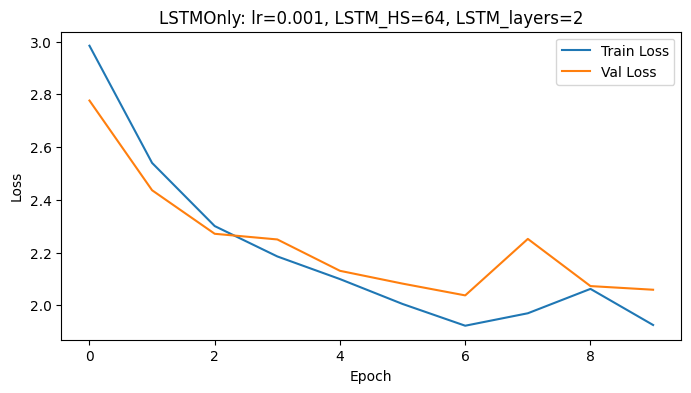


Training LSTMOnly: lr=0.0005, lstm_hidden_size=32, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0805 | Val Loss: 3.0389 | Train ASD Acc: 49.87% | Train Action Acc: 12.57%
Epoch 2/10 | Train Loss: 2.9980 | Val Loss: 2.9589 | Train ASD Acc: 54.40% | Train Action Acc: 18.12%
Epoch 3/10 | Train Loss: 2.8993 | Val Loss: 2.8706 | Train ASD Acc: 57.35% | Train Action Acc: 21.42%
Epoch 4/10 | Train Loss: 2.8002 | Val Loss: 2.7642 | Train ASD Acc: 57.15% | Train Action Acc: 27.38%
Epoch 5/10 | Train Loss: 2.6815 | Val Loss: 2.6874 | Train ASD Acc: 58.12% | Train Action Acc: 30.74%
Epoch 6/10 | Train Loss: 2.6101 | Val Loss: 2.6094 | Train ASD Acc: 61.42% | Train Action Acc: 32.37%
Epoch 7/10 | Train Loss: 2.5563 | Val Loss: 2.5391 | Train ASD Acc: 62.04% | Train Action Acc: 34.25%
Epoch 8/10 | Train Loss: 2.4839 | Val Loss: 2.4880 | Train ASD Acc: 60.92% | Train Action Acc: 36.28%
Epoch 9/10 | Train Loss: 2.4005 | Val Loss: 2.4202 | Train ASD Acc: 63.72% | Train Action Acc: 39.03%
Epoch 10/10 

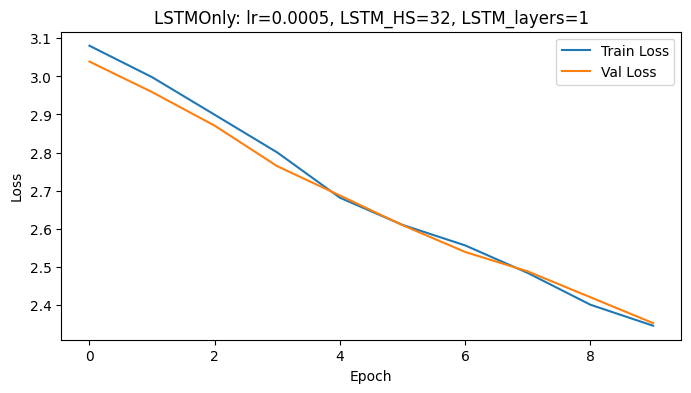


Training LSTMOnly: lr=0.0005, lstm_hidden_size=32, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0758 | Val Loss: 3.0475 | Train ASD Acc: 46.51% | Train Action Acc: 12.47%
Epoch 2/10 | Train Loss: 3.0014 | Val Loss: 2.9363 | Train ASD Acc: 57.05% | Train Action Acc: 20.05%
Epoch 3/10 | Train Loss: 2.8511 | Val Loss: 2.7589 | Train ASD Acc: 59.34% | Train Action Acc: 25.50%
Epoch 4/10 | Train Loss: 2.6451 | Val Loss: 2.5543 | Train ASD Acc: 62.70% | Train Action Acc: 31.81%
Epoch 5/10 | Train Loss: 2.4857 | Val Loss: 2.4734 | Train ASD Acc: 62.95% | Train Action Acc: 34.55%
Epoch 6/10 | Train Loss: 2.3573 | Val Loss: 2.3609 | Train ASD Acc: 65.39% | Train Action Acc: 37.00%
Epoch 7/10 | Train Loss: 2.2723 | Val Loss: 2.2922 | Train ASD Acc: 66.16% | Train Action Acc: 38.73%
Epoch 8/10 | Train Loss: 2.2086 | Val Loss: 2.4550 | Train ASD Acc: 65.45% | Train Action Acc: 42.85%
Epoch 9/10 | Train Loss: 2.2381 | Val Loss: 2.2699 | Train ASD Acc: 64.22% | Train Action Acc: 41.07%
Epoch 10/10 

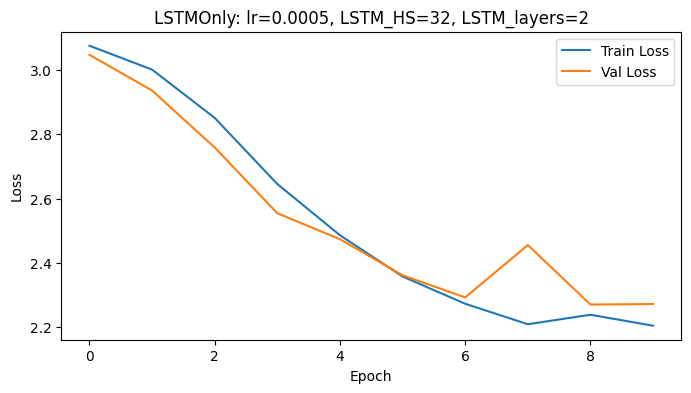


Training LSTMOnly: lr=0.0005, lstm_hidden_size=64, lstm_num_layers=1
Epoch 1/10 | Train Loss: 3.0402 | Val Loss: 2.9804 | Train ASD Acc: 54.66% | Train Action Acc: 15.42%
Epoch 2/10 | Train Loss: 2.8905 | Val Loss: 2.8047 | Train ASD Acc: 56.95% | Train Action Acc: 25.65%
Epoch 3/10 | Train Loss: 2.6730 | Val Loss: 2.5951 | Train ASD Acc: 60.51% | Train Action Acc: 29.31%
Epoch 4/10 | Train Loss: 2.5100 | Val Loss: 2.4362 | Train ASD Acc: 63.66% | Train Action Acc: 34.55%
Epoch 5/10 | Train Loss: 2.4009 | Val Loss: 2.4461 | Train ASD Acc: 62.49% | Train Action Acc: 36.74%
Epoch 6/10 | Train Loss: 2.3738 | Val Loss: 2.3671 | Train ASD Acc: 62.70% | Train Action Acc: 36.79%
Epoch 7/10 | Train Loss: 2.3148 | Val Loss: 2.3484 | Train ASD Acc: 63.00% | Train Action Acc: 39.19%
Epoch 8/10 | Train Loss: 2.2410 | Val Loss: 2.3012 | Train ASD Acc: 65.09% | Train Action Acc: 41.32%
Epoch 9/10 | Train Loss: 2.1950 | Val Loss: 2.2647 | Train ASD Acc: 64.99% | Train Action Acc: 42.19%
Epoch 10/10 

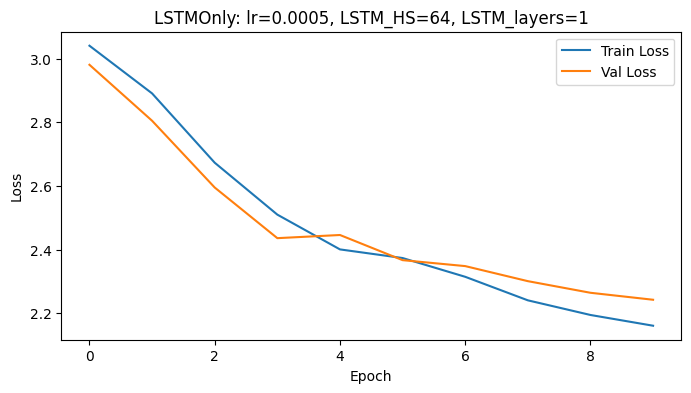


Training LSTMOnly: lr=0.0005, lstm_hidden_size=64, lstm_num_layers=2
Epoch 1/10 | Train Loss: 3.0421 | Val Loss: 2.9492 | Train ASD Acc: 51.96% | Train Action Acc: 15.37%
Epoch 2/10 | Train Loss: 2.8116 | Val Loss: 2.6666 | Train ASD Acc: 59.49% | Train Action Acc: 21.68%
Epoch 3/10 | Train Loss: 2.4933 | Val Loss: 2.4017 | Train ASD Acc: 64.12% | Train Action Acc: 33.38%
Epoch 4/10 | Train Loss: 2.4184 | Val Loss: 2.3859 | Train ASD Acc: 64.94% | Train Action Acc: 35.17%
Epoch 5/10 | Train Loss: 2.2392 | Val Loss: 2.2307 | Train ASD Acc: 66.01% | Train Action Acc: 39.90%
Epoch 6/10 | Train Loss: 2.1295 | Val Loss: 2.2080 | Train ASD Acc: 66.67% | Train Action Acc: 44.94%
Epoch 7/10 | Train Loss: 2.3657 | Val Loss: 2.2940 | Train ASD Acc: 64.89% | Train Action Acc: 36.39%
Epoch 8/10 | Train Loss: 2.1223 | Val Loss: 2.1517 | Train ASD Acc: 65.70% | Train Action Acc: 44.48%
Epoch 9/10 | Train Loss: 2.0175 | Val Loss: 2.0522 | Train ASD Acc: 68.35% | Train Action Acc: 49.72%
Epoch 10/10 

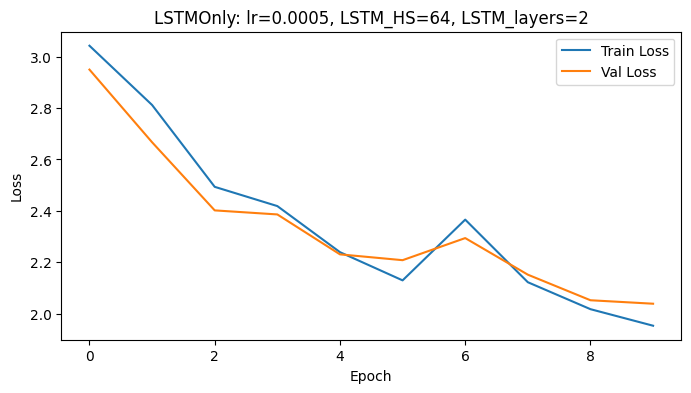


Ablation Study & Hyperparameter Grid Search Results:
     variant      lr  num_filters  lstm_hidden_size  lstm_num_layers  \
0   Proposed  0.0010         32.0              32.0              1.0   
1   Proposed  0.0010         32.0              32.0              2.0   
2   Proposed  0.0010         32.0              64.0              1.0   
3   Proposed  0.0010         32.0              64.0              2.0   
4   Proposed  0.0010         64.0              32.0              1.0   
5   Proposed  0.0010         64.0              32.0              2.0   
6   Proposed  0.0010         64.0              64.0              1.0   
7   Proposed  0.0010         64.0              64.0              2.0   
8   Proposed  0.0005         32.0              32.0              1.0   
9   Proposed  0.0005         32.0              32.0              2.0   
10  Proposed  0.0005         32.0              64.0              1.0   
11  Proposed  0.0005         32.0              64.0              2.0   
12  Propos

In [16]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from io import StringIO

# ------------------------ 1. Authenticate and Access GCS ------------------------
from google.colab import auth
from google.cloud import storage

auth.authenticate_user()  # Authenticate Colab session

project_id = "still-chassis-227311"
BUCKET_NAME = "mmasd"
DATASET_FOLDER_PATH = "3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/"  # Folder inside GCS

client = storage.Client(project=project_id)
bucket = client.bucket(BUCKET_NAME)

# List all CSV files in the dataset folder
def list_all_csv_files(bucket, prefix):
    return [blob.name for blob in bucket.list_blobs(prefix=prefix) if blob.name.endswith(".csv")]

file_list = list_all_csv_files(bucket, DATASET_FOLDER_PATH)
print("Total files found:", len(file_list))
print("Sample files:", file_list[:5])

# ------------------------ 2. Define Custom Dataset ------------------------
class GCSBodyMovementDataset(Dataset):
    def __init__(self, file_list, bucket_name):
        self.file_list = file_list
        self.bucket_name = bucket_name
        self.client = storage.Client()  # Uses default credentials
        self.bucket = self.client.bucket(bucket_name)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        blob = self.bucket.blob(file_path)
        csv_data = blob.download_as_string().decode('utf-8')
        data = pd.read_csv(StringIO(csv_data))

        # Drop identifier and label columns from features
        columns_to_drop = ['Participant_ID', 'ASD_Label', 'Action_Label']
        existing_columns = data.columns
        columns_to_drop = [col for col in columns_to_drop if col in existing_columns]
        features = data.drop(columns=columns_to_drop, axis=1)
        features_tensor = torch.tensor(features.values, dtype=torch.float32)  # shape: (seq_length, input_size)

        # ASD label: if ASD_Label > 0 then 1.0, else 0.0
        asd_label = data['ASD_Label'].iloc[0]
        asd_label = 1.0 if asd_label > 0 else 0.0
        asd_label_tensor = torch.tensor(asd_label, dtype=torch.float32)

        # Action label as integer
        action_label = torch.tensor(data['Action_Label'].iloc[0], dtype=torch.long)

        return features_tensor, asd_label_tensor, action_label

# Create dataset and split into train/validation/test (e.g., 60/20/20)
dataset = GCSBodyMovementDataset(file_list, BUCKET_NAME)
total_samples = len(dataset)
print("Total samples:", total_samples)

train_size = int(0.6 * total_samples)
val_size   = int(0.2 * total_samples)
test_size  = total_samples - train_size - val_size
print("Train/Val/Test sizes:", train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ------------------------ 3. Define Model Variants ------------------------
# Our input feature dimension is assumed to be 75.
# The multi-task model predicts ASD (binary) and Action (multi-class)

# Proposed Model: CNN + BiLSTM
class ProposedModel(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, lstm_hidden_size, lstm_num_layers, num_classes, dropout_rate=0.5):
        super(ProposedModel, self).__init__()
        # CNN for spatial feature extraction
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # BiLSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=num_filters*4, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        # Fully connected heads for ASD and Action
        self.fc_asd = nn.Linear(lstm_hidden_size*2, 1)            # Binary classification
        self.fc_action = nn.Linear(lstm_hidden_size*2, num_classes)  # Multi-class classification

    def forward(self, x):
        # x: (batch, seq_length, input_size)
        x = x.permute(0, 2, 1)  # For CNN: (batch, input_size, seq_length)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))  # Output shape: (batch, channels, reduced_seq)
        x = x.permute(0, 2, 1)  # For LSTM: (batch, reduced_seq, channels)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Last time step
        lstm_out = self.dropout(lstm_out)
        asd_pred = torch.sigmoid(self.fc_asd(lstm_out))
        action_pred = self.fc_action(lstm_out)
        return asd_pred, action_pred

# Ablation Model 1: CNNOnly (Remove LSTM)
class CNNOnlyModel(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, num_classes, dropout_rate=0.5):
        super(CNNOnlyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.adaptive_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        # For multi-task, we duplicate features for both tasks.
        self.fc_asd = nn.Linear(num_filters, 1)
        self.fc_action = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        # x: (batch, seq_length, input_size)
        x = x.permute(0, 2, 1)  # (batch, input_size, seq_length)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.adaptive_pool(x)  # (batch, num_filters, 1)
        x = x.squeeze(-1)          # (batch, num_filters)
        x = self.dropout(x)
        asd_pred = torch.sigmoid(self.fc_asd(x))
        action_pred = self.fc_action(x)
        return asd_pred, action_pred

# Ablation Model 2: LSTMOnly (Remove CNN)
class LSTMOnlyModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, lstm_num_layers, num_classes, dropout_rate=0.5):
        super(LSTMOnlyModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_asd = nn.Linear(lstm_hidden_size*2, 1)
        self.fc_action = nn.Linear(lstm_hidden_size*2, num_classes)

    def forward(self, x):
        # x: (batch, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Last time step
        lstm_out = self.dropout(lstm_out)
        asd_pred = torch.sigmoid(self.fc_asd(lstm_out))
        action_pred = self.fc_action(lstm_out)
        return asd_pred, action_pred

# ------------------------ 4. Training Setup ------------------------
input_size = 75         # Number of features per time step
num_classes = 11        # Action classes
hidden_size = 64        # For LSTM components
num_layers = 2          # LSTM layers

criterion_asd = nn.BCELoss()         # For binary ASD classification
criterion_action = nn.CrossEntropyLoss()  # For multi-class action classification

# Use ReduceLROnPlateau scheduler on validation loss
def run_training(model, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        correct_asd = 0
        correct_action = 0

        for features, asd_labels, action_labels in train_loader:
            features = features.to(device)
            asd_labels = asd_labels.to(device)
            action_labels = action_labels.to(device)

            optimizer.zero_grad()
            asd_pred, action_pred = model(features)
            loss_asd = criterion_asd(asd_pred.view(-1), asd_labels.view(-1))
            loss_action = criterion_action(action_pred, action_labels)
            loss = loss_asd + loss_action
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)
            total_samples += features.size(0)
            correct_asd += ((asd_pred.view(-1) > 0.5) == asd_labels.view(-1)).sum().item()
            correct_action += (torch.argmax(action_pred, dim=1) == action_labels).sum().item()

        epoch_train_loss = running_loss / total_samples
        train_losses.append(epoch_train_loss)
        train_asd_acc = 100 * correct_asd / total_samples
        train_action_acc = 100 * correct_action / total_samples

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for features, asd_labels, action_labels in val_loader:
                features = features.to(device)
                asd_labels = asd_labels.to(device)
                action_labels = action_labels.to(device)

                asd_pred, action_pred = model(features)
                loss_asd = criterion_asd(asd_pred.view(-1), asd_labels.view(-1))
                loss_action = criterion_action(action_pred, action_labels)
                loss = loss_asd + loss_action
                val_loss += loss.item() * features.size(0)
                val_samples += features.size(0)
        epoch_val_loss = val_loss / val_samples
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train ASD Acc: {train_asd_acc:.2f}% | Train Action Acc: {train_action_acc:.2f}%")

    return train_losses, val_losses

# ------------------------ 5. Hyperparameter Grid Search (Ablation Study) ------------------------
learning_rates = [0.001, 0.0005]
num_filters_options = [32, 64]         # For models with CNN components
kernel_size = 3                        # Fixed
lstm_hidden_sizes = [32, 64]           # For models with LSTM components
lstm_num_layers_options = [1, 2]
num_epochs = 10  # For demonstration; increase for real experiments

results = []  # To store configuration and final validation loss

def build_model(variant, lr, **kwargs):
    if variant == 'Proposed':
        model = ProposedModel(input_size=input_size,
                              num_filters=kwargs['num_filters'],
                              kernel_size=kernel_size,
                              lstm_hidden_size=kwargs['lstm_hidden_size'],
                              lstm_num_layers=kwargs['lstm_num_layers'],
                              num_classes=num_classes,
                              dropout_rate=0.5)
    elif variant == 'CNNOnly':
        model = CNNOnlyModel(input_size=input_size,
                             num_filters=kwargs['num_filters'],
                             kernel_size=kernel_size,
                             num_classes=num_classes,
                             dropout_rate=0.5)
    elif variant == 'LSTMOnly':
        model = LSTMOnlyModel(input_size=input_size,
                              lstm_hidden_size=kwargs['lstm_hidden_size'],
                              lstm_num_layers=kwargs['lstm_num_layers'],
                              num_classes=num_classes,
                              dropout_rate=0.5)
    else:
        raise ValueError("Unknown model variant.")
    return model.to(device)

model_variants = ['Proposed', 'CNNOnly', 'LSTMOnly']

for variant in model_variants:
    for lr in learning_rates:
        if variant in ['Proposed', 'CNNOnly']:
            for num_filters in num_filters_options:
                if variant == 'Proposed':
                    for lstm_hidden_size in lstm_hidden_sizes:
                        for lstm_num_layers in lstm_num_layers_options:
                            print(f"\nTraining {variant}: lr={lr}, num_filters={num_filters}, "
                                  f"lstm_hidden_size={lstm_hidden_size}, lstm_num_layers={lstm_num_layers}")
                            model = build_model(variant, lr, num_filters=num_filters,
                                                lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers)
                            optimizer = optim.Adam(model.parameters(), lr=lr)
                            train_losses, val_losses = run_training(model, optimizer, num_epochs=num_epochs)

                            results.append({
                                'variant': variant,
                                'lr': lr,
                                'num_filters': num_filters,
                                'lstm_hidden_size': lstm_hidden_size,
                                'lstm_num_layers': lstm_num_layers,
                                'final_val_loss': val_losses[-1]
                            })
                            # Plot loss curves
                            plt.figure(figsize=(8, 4))
                            plt.plot(train_losses, label='Train Loss')
                            plt.plot(val_losses, label='Val Loss')
                            plt.title(f"{variant}: lr={lr}, NF={num_filters}, LSTM_HS={lstm_hidden_size}, LSTM_layers={lstm_num_layers}")
                            plt.xlabel("Epoch")
                            plt.ylabel("Loss")
                            plt.legend()
                            plt.show()
                else:  # CNNOnly
                    print(f"\nTraining {variant}: lr={lr}, num_filters={num_filters}")
                    model = build_model(variant, lr, num_filters=num_filters)
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    train_losses, val_losses = run_training(model, optimizer, num_epochs=num_epochs)

                    results.append({
                        'variant': variant,
                        'lr': lr,
                        'num_filters': num_filters,
                        'lstm_hidden_size': None,
                        'lstm_num_layers': None,
                        'final_val_loss': val_losses[-1]
                    })
                    plt.figure(figsize=(8, 4))
                    plt.plot(train_losses, label='Train Loss')
                    plt.plot(val_losses, label='Val Loss')
                    plt.title(f"{variant}: lr={lr}, NF={num_filters}")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()
        else:  # LSTMOnly
            for lstm_hidden_size in lstm_hidden_sizes:
                for lstm_num_layers in lstm_num_layers_options:
                    print(f"\nTraining {variant}: lr={lr}, lstm_hidden_size={lstm_hidden_size}, lstm_num_layers={lstm_num_layers}")
                    model = build_model(variant, lr, lstm_hidden_size=lstm_hidden_size, lstm_num_layers=lstm_num_layers)
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    train_losses, val_losses = run_training(model, optimizer, num_epochs=num_epochs)

                    results.append({
                        'variant': variant,
                        'lr': lr,
                        'num_filters': None,
                        'lstm_hidden_size': lstm_hidden_size,
                        'lstm_num_layers': lstm_num_layers,
                        'final_val_loss': val_losses[-1]
                    })
                    plt.figure(figsize=(8, 4))
                    plt.plot(train_losses, label='Train Loss')
                    plt.plot(val_losses, label='Val Loss')
                    plt.title(f"{variant}: lr={lr}, LSTM_HS={lstm_hidden_size}, LSTM_layers={lstm_num_layers}")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

# Summarize all hyperparameter search results
df_results = pd.DataFrame(results)
print("\nAblation Study & Hyperparameter Grid Search Results:")
print(df_results)


Ablation Study & Hyperparameter Grid Search Results:
     variant      lr  num_filters  lstm_hidden_size  lstm_num_layers  \
0   Proposed  0.0010         32.0              32.0              1.0   
1   Proposed  0.0010         32.0              32.0              2.0   
2   Proposed  0.0010         32.0              64.0              1.0   
3   Proposed  0.0010         32.0              64.0              2.0   
4   Proposed  0.0010         64.0              32.0              1.0   
5   Proposed  0.0010         64.0              32.0              2.0   
6   Proposed  0.0010         64.0              64.0              1.0   
7   Proposed  0.0010         64.0              64.0              2.0   
8   Proposed  0.0010         32.0              32.0              1.0   
9   Proposed  0.0010         32.0              32.0              2.0   
10  Proposed  0.0010         32.0              64.0              1.0   
11  Proposed  0.0010         32.0              64.0              2.0   
12  Propose

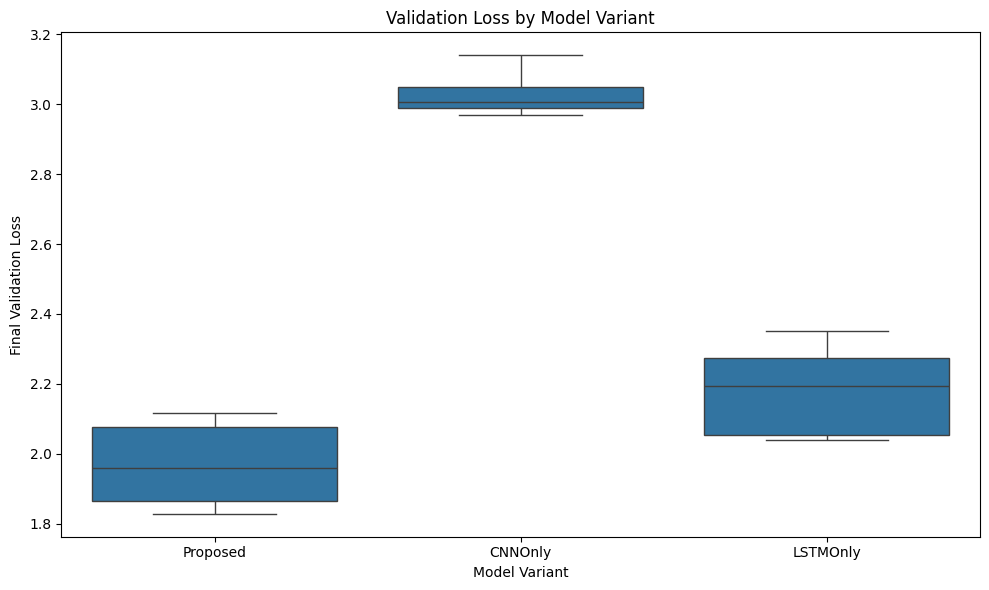

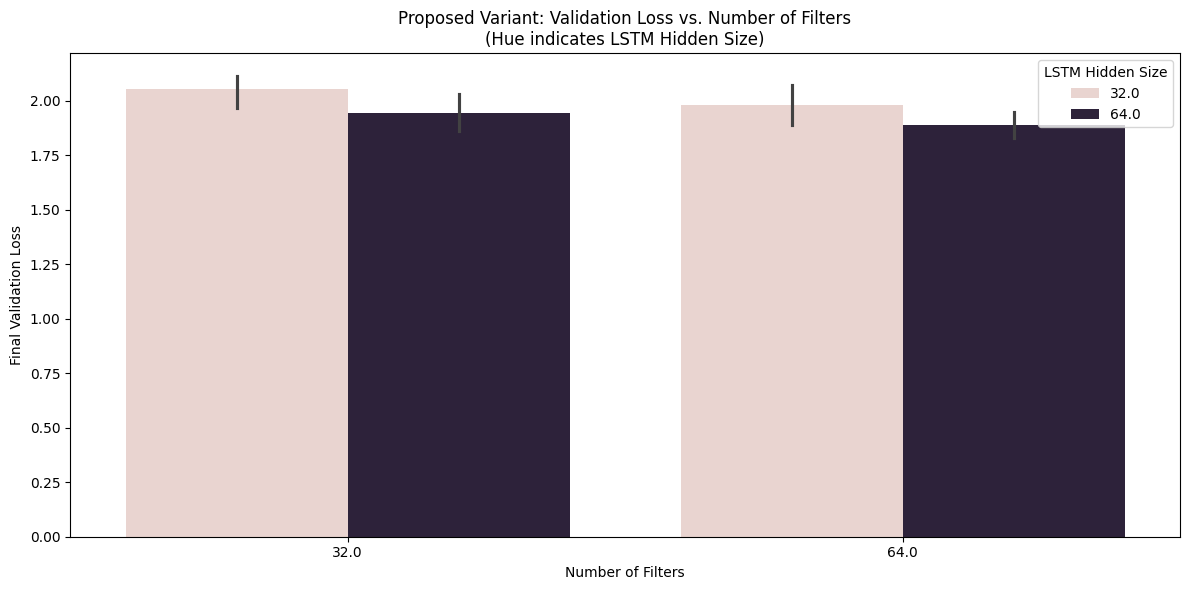

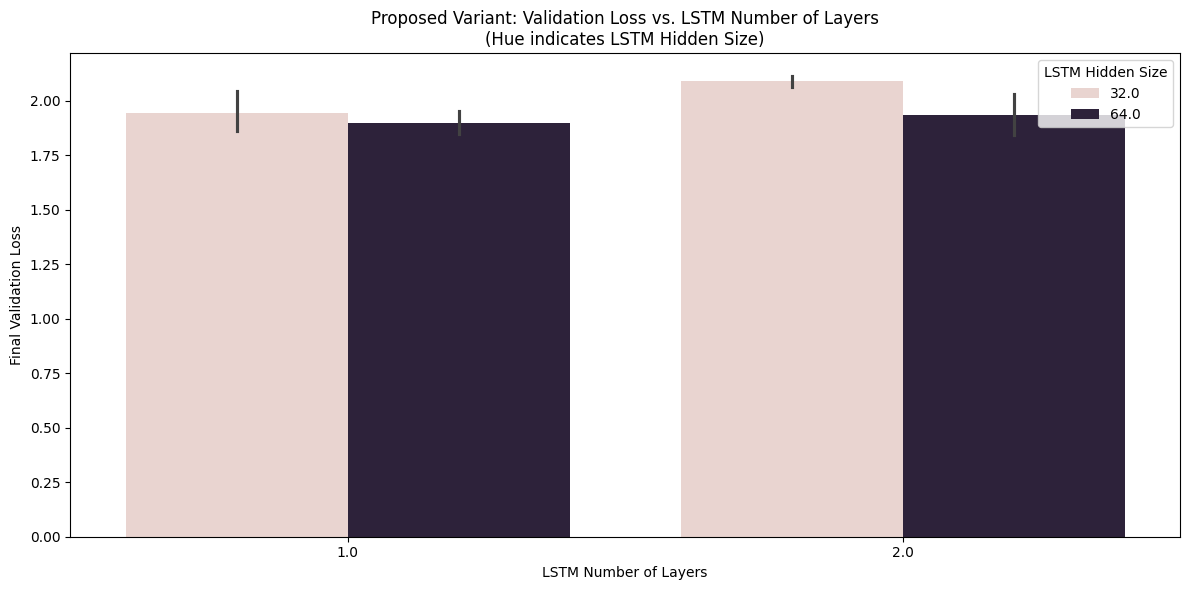

No data found for lr=0.0005 and num_filters=32 in the Proposed variant.

Best configuration overall:
    variant     lr  num_filters  lstm_hidden_size  lstm_num_layers  \
7  Proposed  0.001         64.0              64.0              2.0   

   final_val_loss  
7        1.827994  


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load or Create Your Results DataFrame
# -------------------------------
# For demonstration, we create the DataFrame manually using your provided table.
data = {
    'variant': (['Proposed']*16 + ['CNNOnly']*4 + ['LSTMOnly']*8),
    'lr': ([0.0010]*16 + [0.0010, 0.0010, 0.0005, 0.0005] + [0.0010]*4 + [0.0005]*4),
    'num_filters': ([32, 32, 32, 32, 64, 64, 64, 64, 32, 32, 32, 32, 64, 64, 64, 64,
                     32, 64, 32, 64,
                     None, None, None, None, None, None, None, None]),
    'lstm_hidden_size': ([32, 32, 64, 64, 32, 32, 64, 64, 32, 32, 64, 64, 32, 32, 64, 64,
                           None, None, None, None,
                           32, 32, 64, 64, 32, 32, 64, 64]),
    'lstm_num_layers': ([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
                         None, None, None, None,
                         1, 2, 1, 2, 1, 2, 1, 2]),
    'final_val_loss': [1.919063, 2.107608, 1.864077, 1.860624,
                       1.834453, 2.048831, 1.828193, 1.827994,
                       2.078441, 2.117343, 1.979402, 2.077578,
                       1.939027, 2.094911, 1.920352, 1.979263,
                       3.020797, 2.994484, 3.140453, 2.968861,
                       2.284082, 2.038264, 2.143240, 2.059211,
                       2.352353, 2.271429, 2.242781, 2.038720]
}

df = pd.DataFrame(data)
print("Ablation Study & Hyperparameter Grid Search Results:")
print(df)

# -------------------------------
# 2. Visualize Overall Performance by Variant
# -------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='variant', y='final_val_loss', data=df)
plt.title("Validation Loss by Model Variant")
plt.xlabel("Model Variant")
plt.ylabel("Final Validation Loss")
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Analyze Proposed Model Hyperparameters
# -------------------------------
# Filter the DataFrame for the Proposed variant only:
df_proposed = df[df['variant'] == 'Proposed']

# a. Bar plot comparing final validation loss vs. number of filters, with hue as LSTM hidden size.
plt.figure(figsize=(12, 6))
sns.barplot(x='num_filters', y='final_val_loss', hue='lstm_hidden_size', data=df_proposed)
plt.title("Proposed Variant: Validation Loss vs. Number of Filters\n(Hue indicates LSTM Hidden Size)")
plt.xlabel("Number of Filters")
plt.ylabel("Final Validation Loss")
plt.legend(title="LSTM Hidden Size")
plt.tight_layout()
plt.show()

# b. Bar plot comparing final validation loss for different LSTM layer configurations.
plt.figure(figsize=(12, 6))
sns.barplot(x='lstm_num_layers', y='final_val_loss', hue='lstm_hidden_size', data=df_proposed)
plt.title("Proposed Variant: Validation Loss vs. LSTM Number of Layers\n(Hue indicates LSTM Hidden Size)")
plt.xlabel("LSTM Number of Layers")
plt.ylabel("Final Validation Loss")
plt.legend(title="LSTM Hidden Size")
plt.tight_layout()
plt.show()

# c. Heatmap: For a fixed learning rate and number of filters, examine the effect of LSTM hidden size vs. number of layers.
# For example, select lr = 0.0005 and num_filters = 32
df_subset = df_proposed[(df_proposed['lr'] == 0.0005) & (df_proposed['num_filters'] == 32)]
if not df_subset.empty:
    pivot = df_subset.pivot(index='lstm_hidden_size', columns='lstm_num_layers', values='final_val_loss')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Heatmap: Proposed Variant (lr=0.0005, num_filters=32)")
    plt.xlabel("LSTM Number of Layers")
    plt.ylabel("LSTM Hidden Size")
    plt.tight_layout()
    plt.show()
else:
    print("No data found for lr=0.0005 and num_filters=32 in the Proposed variant.")

# -------------------------------
# 4. Identify Best Configuration
# -------------------------------
# Sort the DataFrame by final validation loss to find the best-performing configuration.
best_config = df.sort_values("final_val_loss").head(1)
print("\nBest configuration overall:")
print(best_config)
